In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd

In [3]:
# ## Exmple that shows extent of sliding window ###
# import torch

# shape = img.shape
# # Z ...
# start = [0, shape[0]//4, shape[0]//8, shape[0]-112]
# end = [112, shape[0]//4+112, shape[0]//8+112, shape[0]]
# # Y
# start_y = [0, shape[1]-176, shape[1]//24, shape[1]//12, shape[1]//6, shape[1] - shape[1]//4 - 176, shape[1] - shape[1]//6 - 176]
# end_y = [176, shape[1], shape[1]//24+176, shape[1]//12 + 176, shape[1]//6 + 176, shape[1] - shape[1]//4, shape[1] - shape[1]//6]
# # X
# start_x = [0, shape[1]-176, shape[1]//4, shape[1]//6, shape[1] - shape[1]//4 - 176, shape[1] - shape[1]//6 - 176]
# end_x = [176, shape[1],  shape[1]//4+176, shape[1]//6 + 176, shape[1] - shape[1]//4, shape[1] - shape[1]//6]
# reference_ = torch.zeros(img.shape)
# reference = torch.zeros(img.shape)
# iter_=0
# for i, val in enumerate(start):
#     for j, v in enumerate(start_y):
#         for k, va in enumerate(start_x):
#             im = img[val:end[i], v:end_y[j], va:end_x[k]]
#             reference_[val:end[i], v:end_y[j], va:end_x[k]]+=1
#             # RUN THE NETWORK
#             # output = self.net(im)
#             output=torch.ones(im.shape)
#             reference[val:end[i], v:end_y[j], va:end_x[k]] += output
#             iter_+=1

In [4]:
###### AFTER APPLYING ALL 5 folds on test set, calculate DICE/HAUSDORFF
import monai.metrics as met
import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    for i, slice_ in enumerate(targ):
        if slice_.max()>0:
            crop_to=i
            break
    
    #####################################
    # ONLY IF NEED TO CROP TO REFERENCE #
    shape_before=targ.size()
    outs = outs[crop_to:]
    targ = targ[crop_to:]
    shape=targ.size()
    #######################
    
    print('Before crop', shape_before)
    print('After crop', shape)
    
    class_ = torch.max(targ)
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ == i] = 1
        targets_out[0, i][outs == i] = 1

    return targets_out, targets_dice

def fix_outputs(out_, val=292):
    # Parotids...
    sl = out_[:,:,:val//2]
    sl[sl==6] = 7
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==7] = 6
    out_[:,:,val//2:]=sl

    # # Acoustics...
    sl = out_[:,:,:val//2]
    sl[sl==8] = 9
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==9] = 8
    out_[:,:,val//2:]=sl

    # Plexus
    sl = out_[:,:,:val//2]
    sl[sl==11] = 10
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==10] = 11
    out_[:,:,val//2:]=sl

    # Lens
    sl = out_[:,:,:val//2]
    sl[sl==12] = 13
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==13] = 12
    out_[:,:,val//2:]=sl

    # Eyes
    sl = out_[:,:,:val//2]
    sl[sl==14] = 15
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==15] = 14
    out_[:,:,val//2:]=sl

    # Eyes
    sl = out_[:,:,:val//2]
    sl[sl==14] = 15
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==15] = 14
    out_[:,:,val//2:]=sl

    # # Optic Nerves...
    sl = out_[:,:,:val//2]
    sl[sl==16] = 17
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==17] = 16
    out_[:,:,val//2:]=sl
    
    return out_

In [5]:
import glob
targ = glob.glob('/Users/joemarsilla/Downloads/radcure_ensemble_test/targ*')
targ.sort()

In [6]:
outputs = torch.from_numpy(np.load(targ[0].replace('targ', 'outs')))
targets = torch.from_numpy(np.load(targ[0]))
outputs_, targets_ = onehot(outputs, targets, argmax=False)
# outputs = fix_outputs(outputs)
# outputs, targets = onehot(outputs, targets, argmax=False)

Before crop torch.Size([195, 512, 512])
After crop torch.Size([165, 512, 512])
tensor(19)


In [7]:
outputs_.shape

torch.Size([1, 20, 165, 512, 512])

In [6]:
dce_ = met.compute_meandice(outputs_, targets_)

In [7]:
dce_.mean()

tensor(0.8329)

In [8]:
len(dce_[0])
# NO CORRECTION NEEDED

20

In [9]:
space = (1,1,2)
voxel = np.prod(space)

In [15]:
dices_ = []
hd95_ = []
sds_ = []
patient_ = []
oar_ = []
vols = []

chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

for i, path in enumerate(targ):
    # load images...
    pat = path.split('/')[-1].split('_')[1].split('.')[0]
    outputs = torch.from_numpy(np.load(path.replace('targ', 'outs')))
    targets = torch.from_numpy(np.load(path))
    #     outputs = fix_outputs(outputs)
    outputs, targets = onehot(outputs, targets, argmax=False)
    # metrics...
    hd  = met.compute_hausdorff_distance(outputs, targets, percentile=95, include_background=True)
    dce = met.compute_meandice(outputs, targets)
    sd  = met.compute_average_surface_distance(outputs, targets, include_background=True)
    print(i, dce.mean())
    # correlate to OAR...
    for j, val in enumerate(range(1,20)):
        oar_.append(chosen[j])
        patient_.append(pat)
        sds_.append(sd[0][j+1])
        dices_.append(dce[0][j+1])
        hd95_.append(hd[0][j+1])
        vols.append(voxel*outputs[0][j+1].sum().item())
    
    print(f'Done {i}, {pat}.')
# implement array modification....

Before crop torch.Size([195, 512, 512])
After crop torch.Size([165, 512, 512])
tensor(19)
0 tensor(0.8329)
Done 0, 0.
Before crop torch.Size([203, 512, 512])
After crop torch.Size([198, 512, 512])
tensor(19)
1 tensor(0.8004)
Done 1, 10.
Before crop torch.Size([161, 512, 512])
After crop torch.Size([131, 512, 512])
tensor(19)
2 tensor(0.6983)
Done 2, 11.
Before crop torch.Size([194, 512, 512])
After crop torch.Size([160, 512, 512])
tensor(19)
3 tensor(0.7899)
Done 3, 12.
Before crop torch.Size([192, 512, 512])
After crop torch.Size([162, 512, 512])
tensor(19)
4 tensor(0.7405)
Done 4, 13.
Before crop torch.Size([164, 512, 512])
After crop torch.Size([157, 512, 512])
tensor(19)
5 tensor(0.8405)
Done 5, 14.
Before crop torch.Size([185, 512, 512])
After crop torch.Size([160, 512, 512])
tensor(19)
6 tensor(0.8542)
Done 6, 15.
Before crop torch.Size([203, 512, 512])
After crop torch.Size([203, 512, 512])
tensor(19)
7 tensor(0.7548)
Done 7, 16.
Before crop torch.Size([182, 512, 512])
After cro

/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 12 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 13 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 19 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3

25 tensor(0.6052)
Done 25, 32.
Before crop torch.Size([206, 512, 512])
After crop torch.Size([183, 512, 512])
tensor(19)
26 tensor(0.7885)
Done 26, 33.
Before crop torch.Size([186, 512, 512])
After crop torch.Size([168, 512, 512])
tensor(19)
27 tensor(0.6988)
Done 27, 34.
Before crop torch.Size([213, 512, 512])
After crop torch.Size([184, 512, 512])
tensor(19)
28 tensor(0.6463)
Done 28, 35.
Before crop torch.Size([145, 512, 512])
After crop torch.Size([127, 512, 512])
tensor(19)
29 tensor(0.7992)
Done 29, 36.
Before crop torch.Size([192, 512, 512])
After crop torch.Size([173, 512, 512])
tensor(19)
30 tensor(0.7672)
Done 30, 37.
Before crop torch.Size([163, 512, 512])
After crop torch.Size([143, 512, 512])
tensor(19)
31 tensor(0.8233)
Done 31, 38.
Before crop torch.Size([195, 512, 512])
After crop torch.Size([180, 512, 512])
tensor(19)
32 tensor(0.8265)
Done 32, 39.
Before crop torch.Size([191, 512, 512])
After crop torch.Size([163, 512, 512])
tensor(19)
33 tensor(0.7747)
Done 33, 3.
Be

In [14]:
outputs[0][j+1].sum().item()

20282.0

In [10]:
oar_ = chosen[val] for val in oar

SyntaxError: invalid syntax (1746052403.py, line 1)

In [16]:
data_ = {}
data_['OAR'] = oar_
data_['Patient'] = patient_
data_['VolDice'] = [d.item() for d in dices_]
data_['95HD'] = [h.item() for h in hd95_]
data_['SurfDice'] = [s.item() for s in sds_]
data_['Volume'] = vols
data_['Observer'] = ['rc_radiologist' for s in sds_]

In [17]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_corrected_01072022.csv')
data_.head()

OAR Patient   VolDice      95HD  SurfDice   Volume        Observer
0   BSTEM       0  0.850081  3.000000  1.134316  40564.0  rc_radiologist
1   SPCOR       0  0.827113  2.236068  1.092190  40662.0  rc_radiologist
2   ESOPH       0  0.833083  3.162278  1.103672  19698.0  rc_radiologist
3  LARYNX       0  0.895342  2.000000  0.853980  41646.0  rc_radiologist
4    MAND       0  0.951560  1.000000  0.346290  86006.0  rc_radiologist

In [4]:
import pandas as pd
data = pd.read_csv('/Users/joemarsilla/OARensemble2021_corrected_01072022.csv', index_col=0)

In [2]:
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2295/3904161389.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2295/3904161389.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


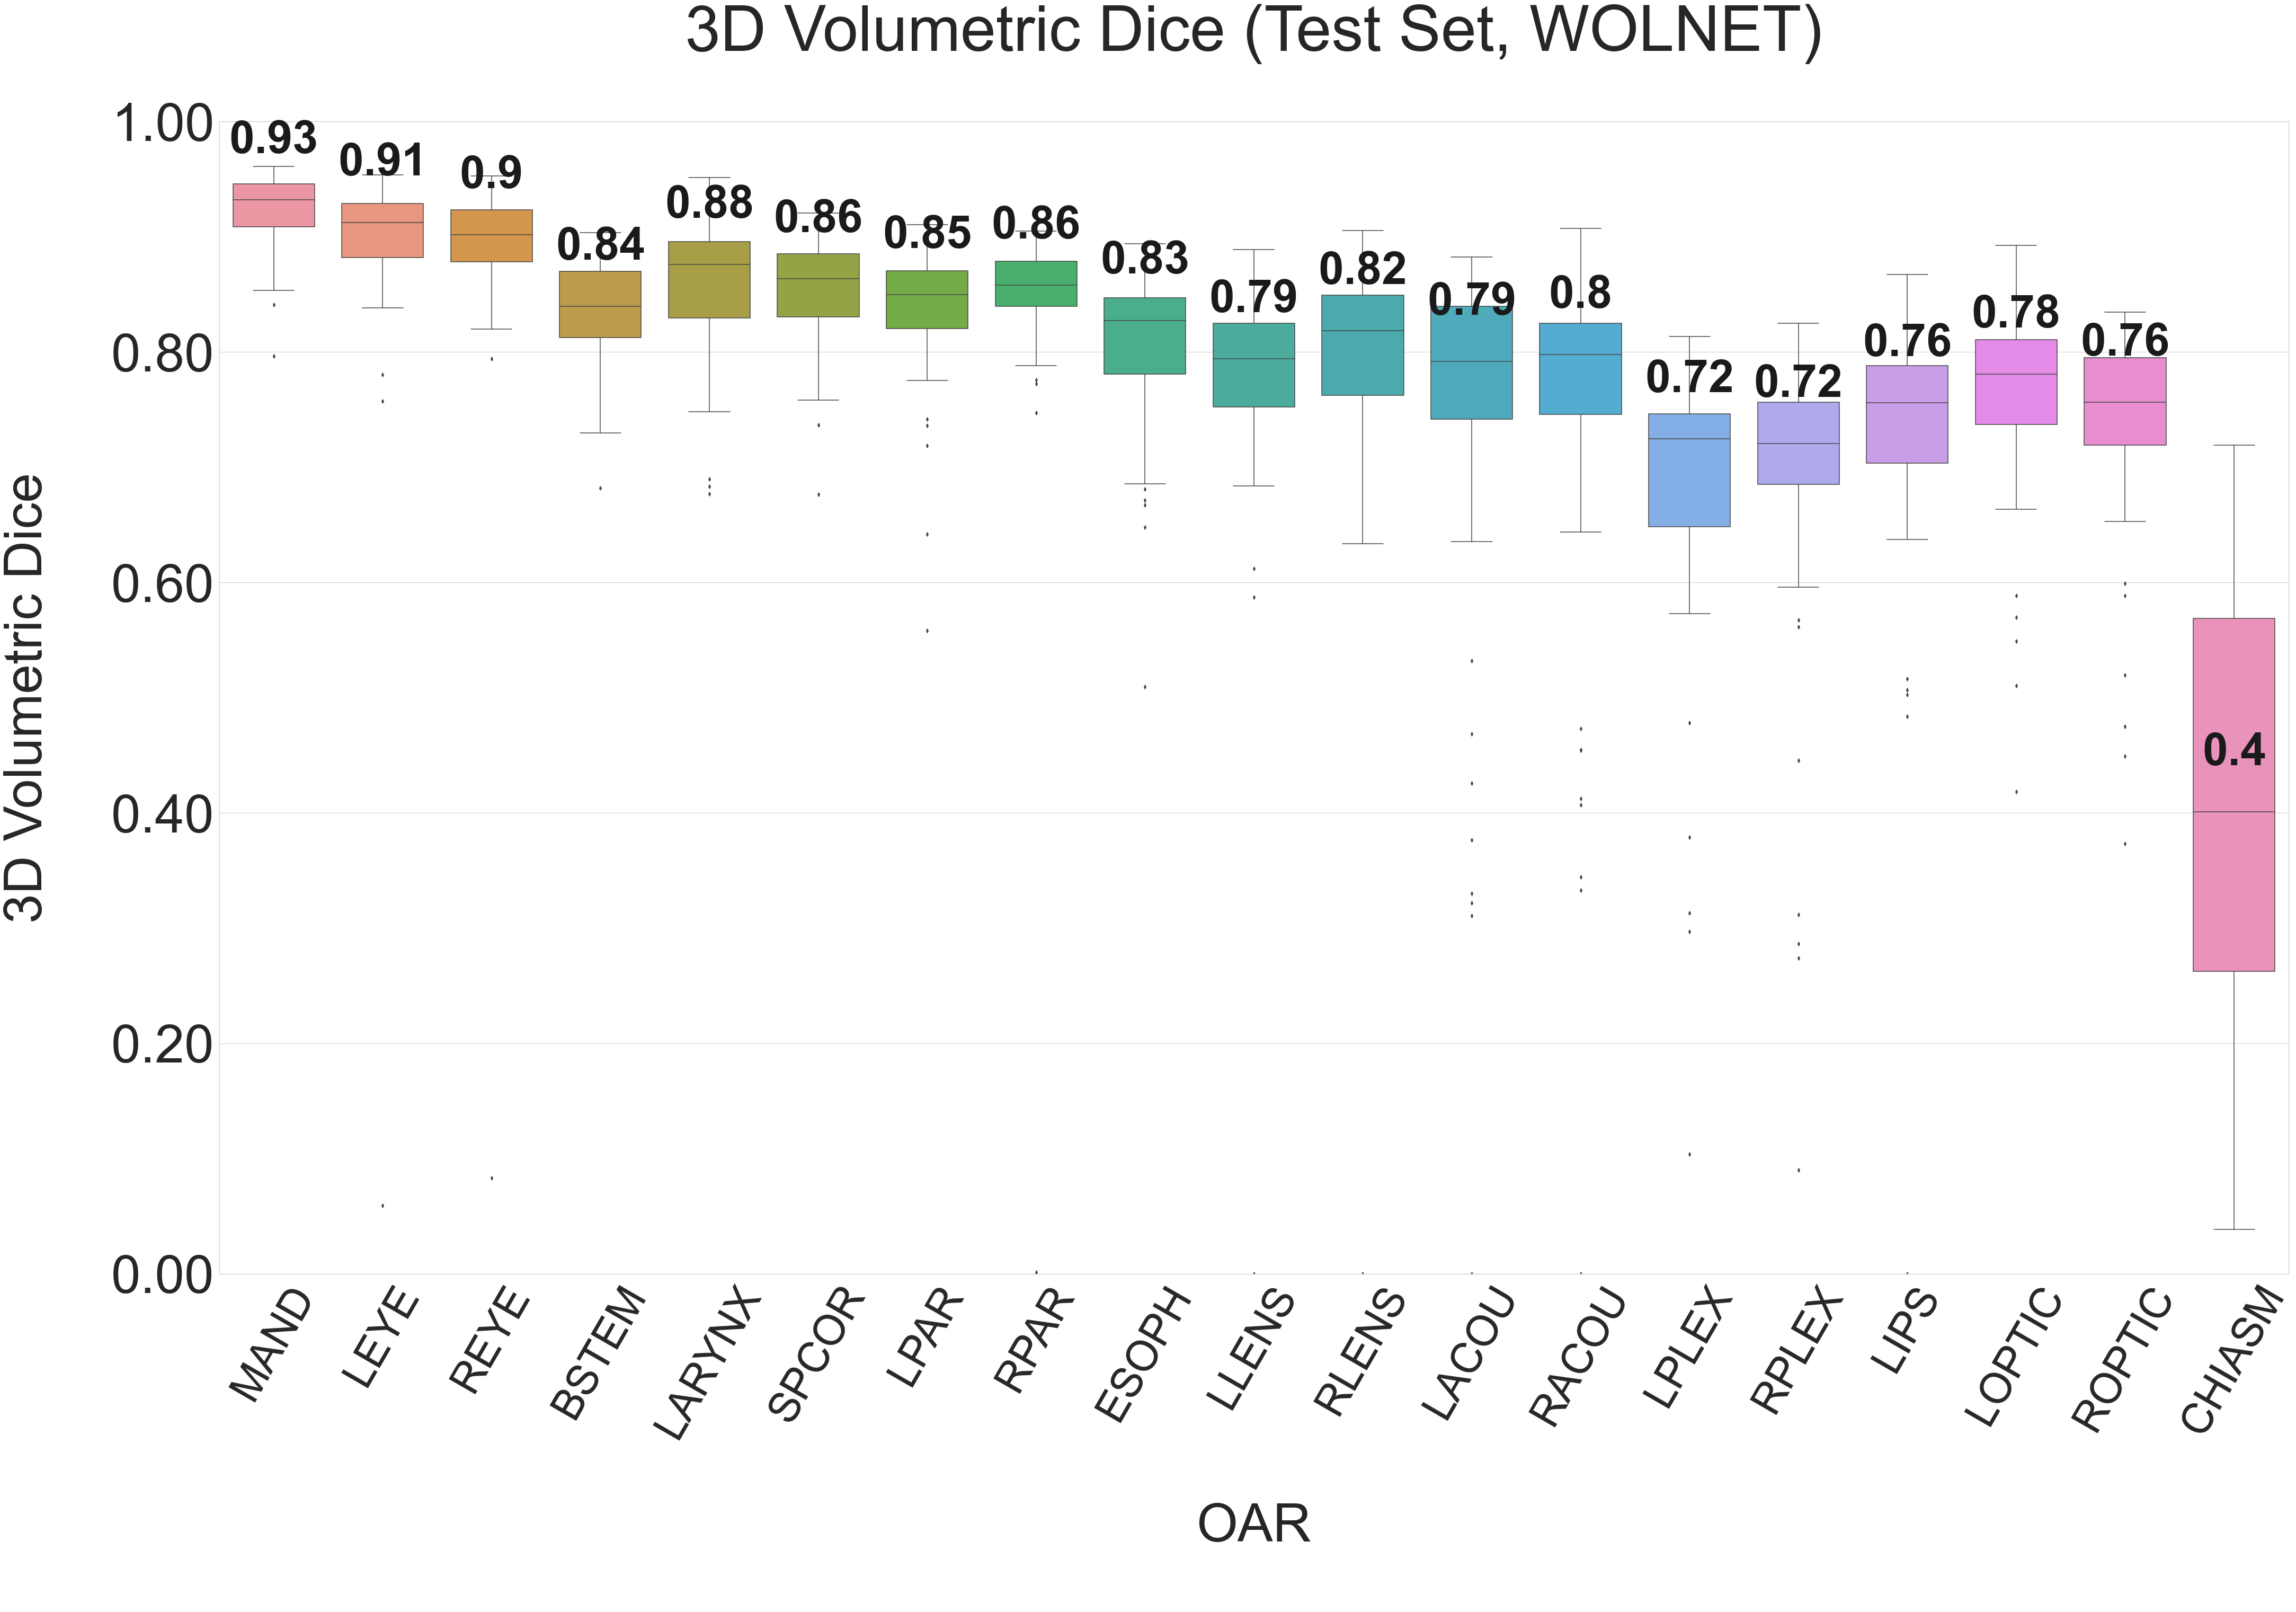

In [8]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('3D Volumetric Dice (Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data.OAR = data.OAR.astype("category")
data.OAR.cat.set_categories(rois, inplace=True)
data.sort_values(["OAR"])
medians = data.groupby(['OAR'])['VolDice'].median()
vertical_offset = data['VolDice'].median() * 0.05 # offset from median for display
ax = sea.boxplot(data=data, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.75, dodge=False)
ax.set_ylim(0,1)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
ax.legend_.remove()

In [15]:
rois

['MAND',
 'LEYE',
 'REYE',
 'BSTEM',
 'LARYNX',
 'SPCOR',
 'LPAR',
 'RPAR',
 'ESOPH',
 'LLENS',
 'RLENS',
 'LACOU',
 'RACOU',
 'LPLEX',
 'RPLEX',
 'LIPS',
 'LOPTIC',
 'ROPTIC',
 'CHIASM']

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


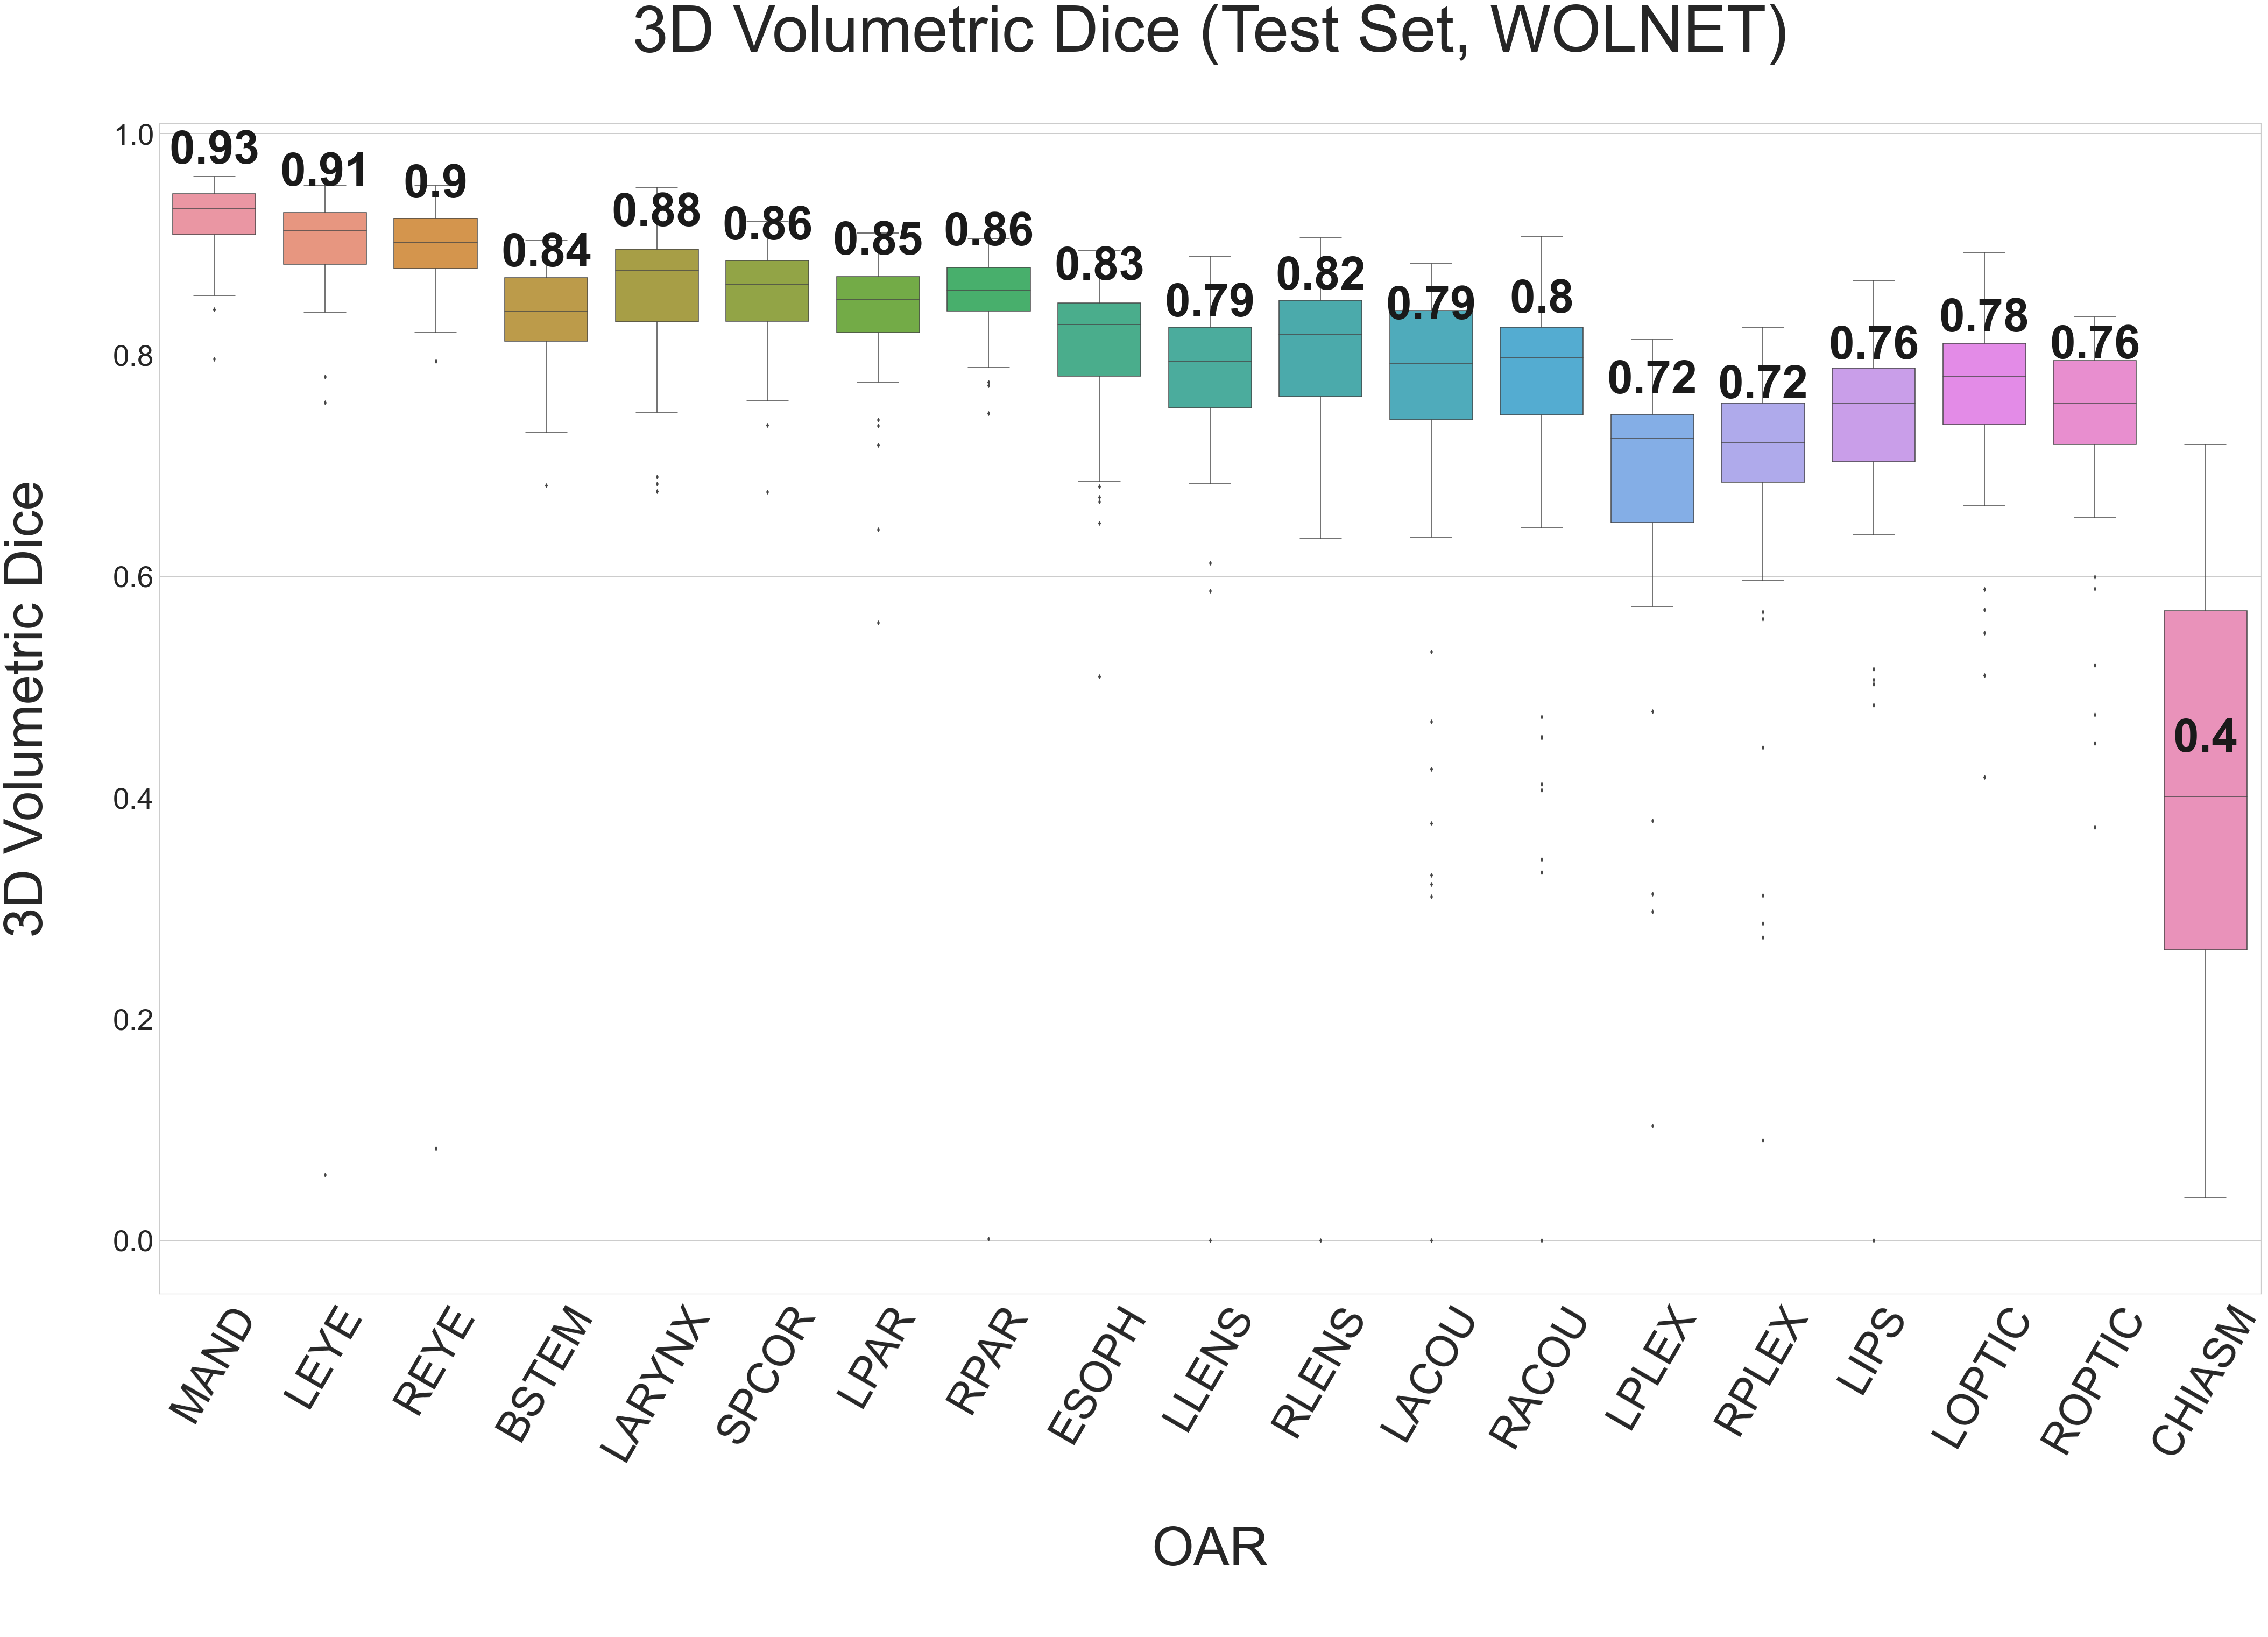

In [9]:
# CORRECTED ENSEMBLE
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('3D Volumetric Dice (Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data_.OAR = data_.OAR.astype("category")
data_.OAR.cat.set_categories(rois, inplace=True)
data_.sort_values(["OAR"])
medians = data_.groupby(['OAR'])['VolDice'].median()
vertical_offset = data_['VolDice'].median() * 0.05 # offset from median for display
ax = sea.boxplot(data=data_, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.75, dodge=False)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
ax.legend_.remove()

/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2295/2138747361.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2295/2138747361.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


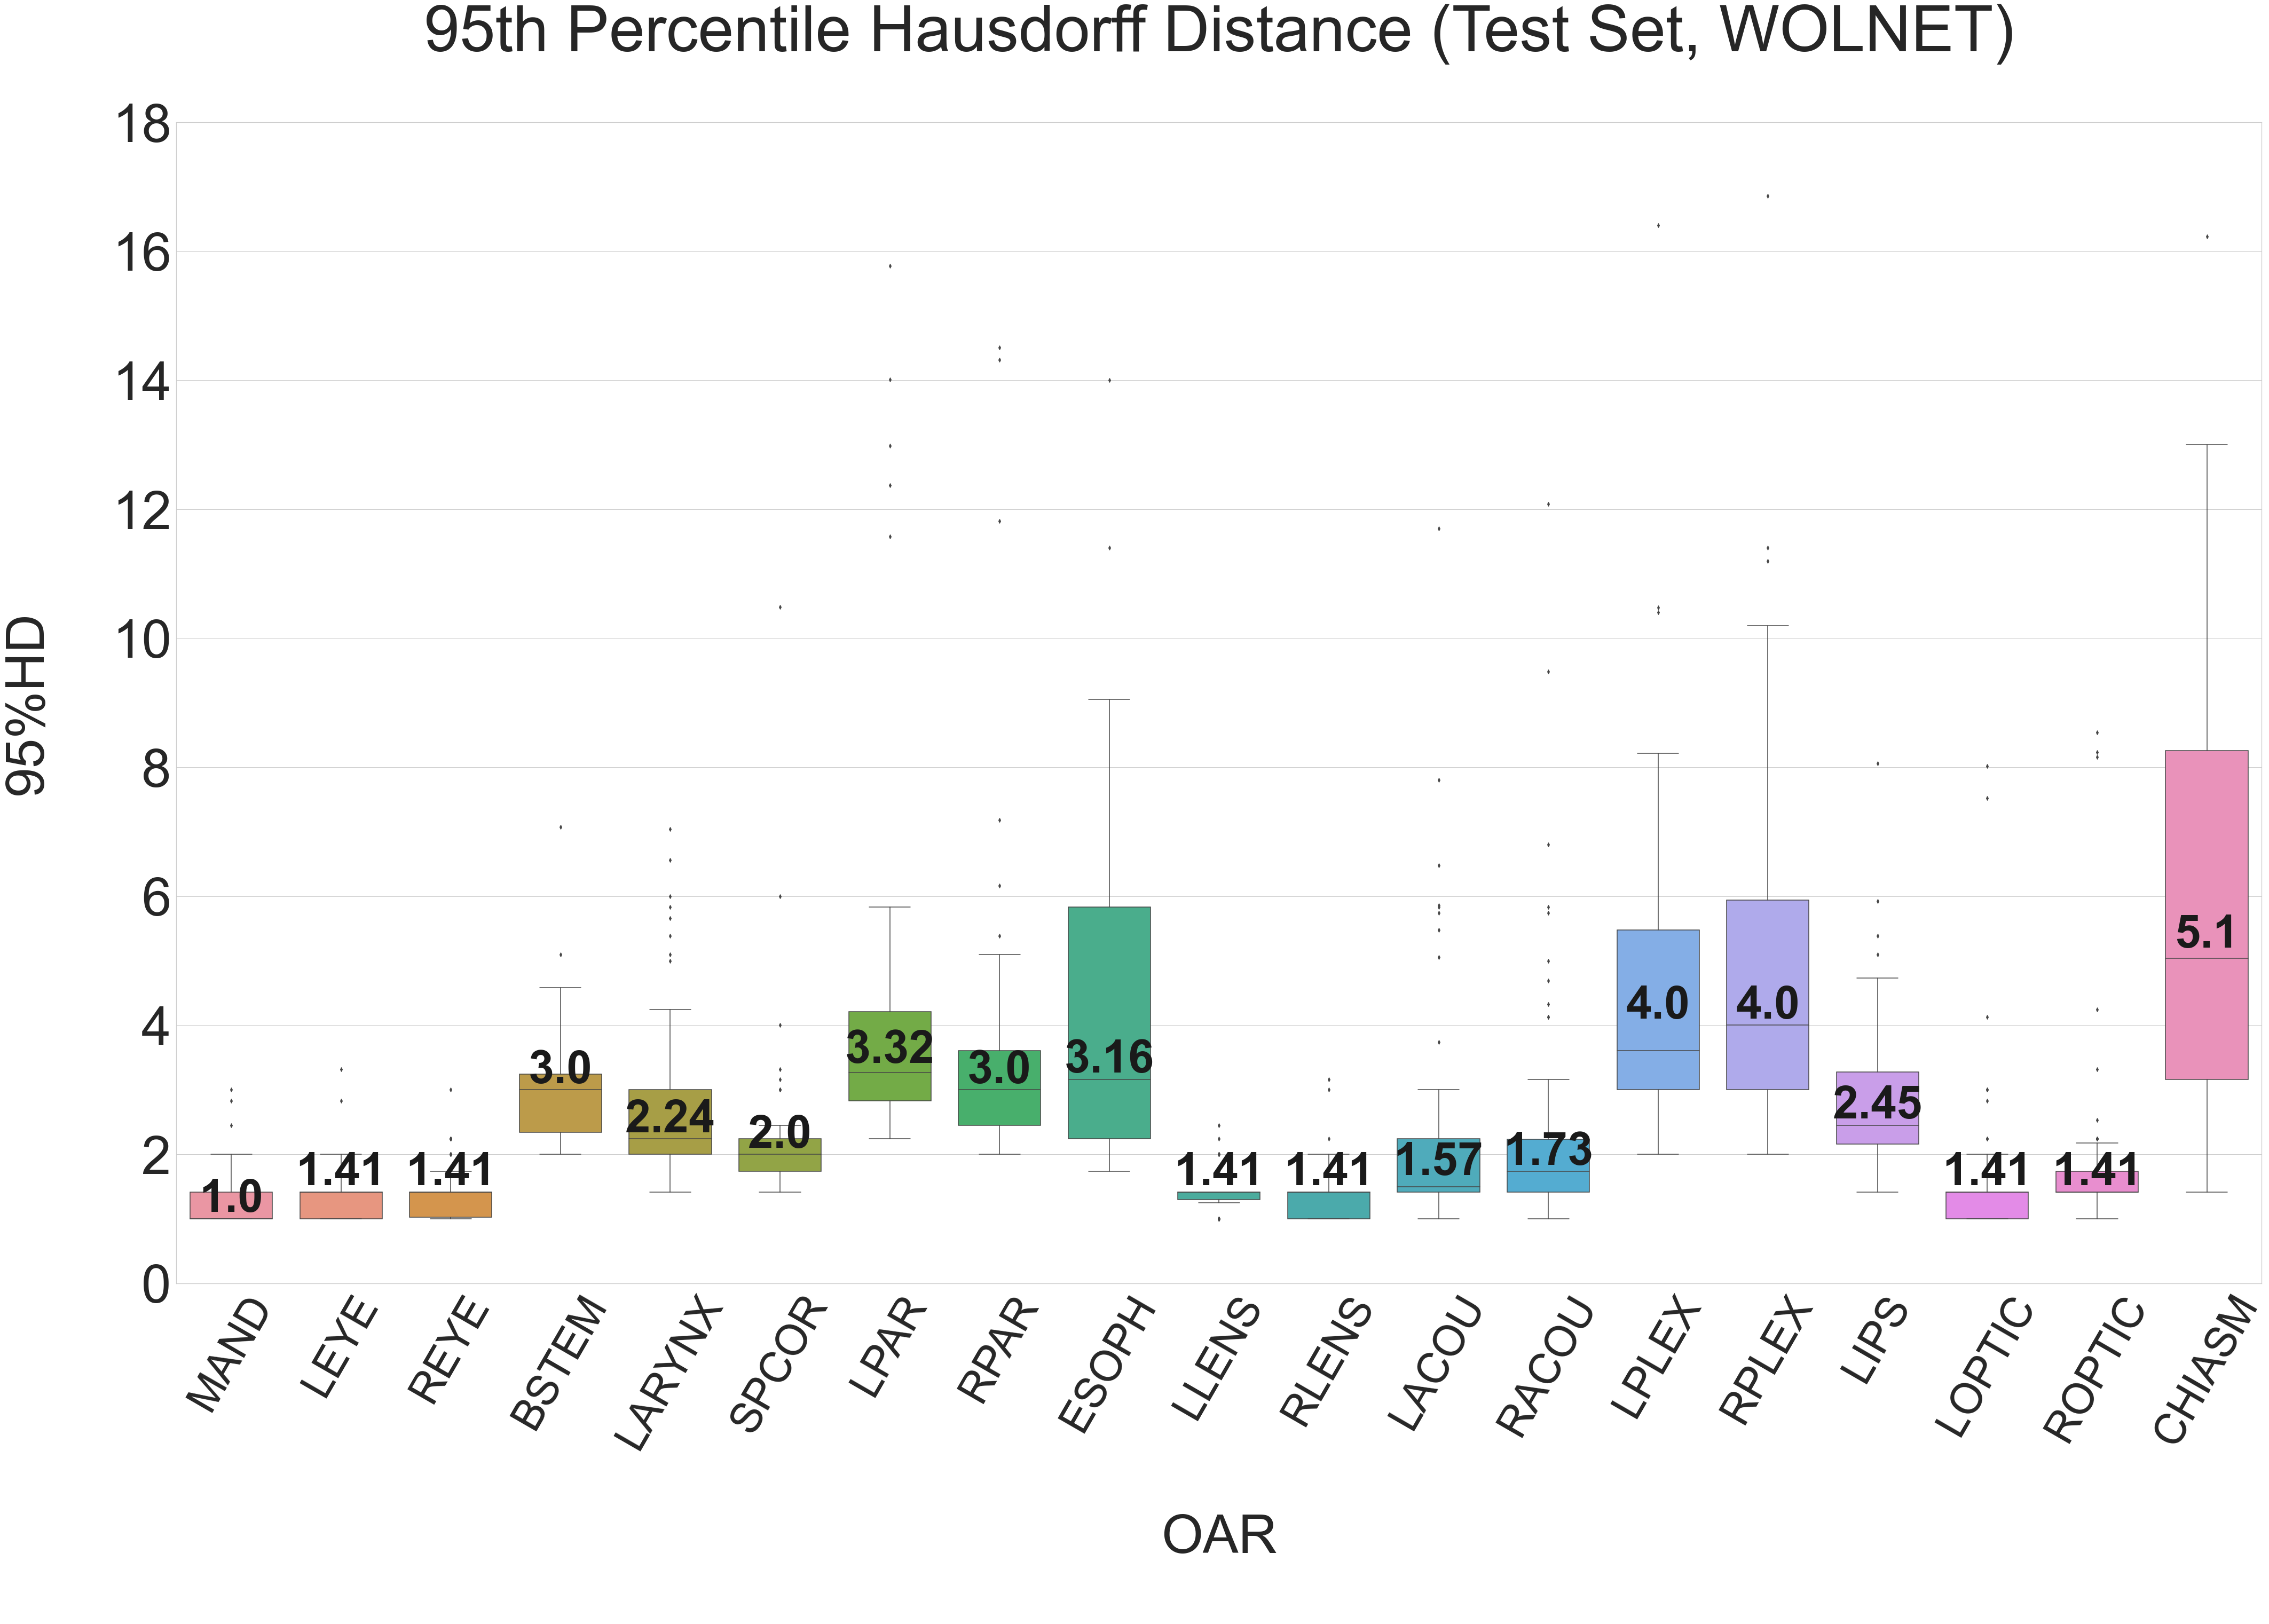

In [13]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data[data["95HD"]<17.5], x="OAR", y="95HD", hue="OAR", hue_order=rois, width=.75, dodge=False)
ax.set_ylim(0,18)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
medians = data.groupby(['OAR'])['95HD'].median()
vertical_offset = data['95HD'].median() * 0.05 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
ax.legend_.remove()

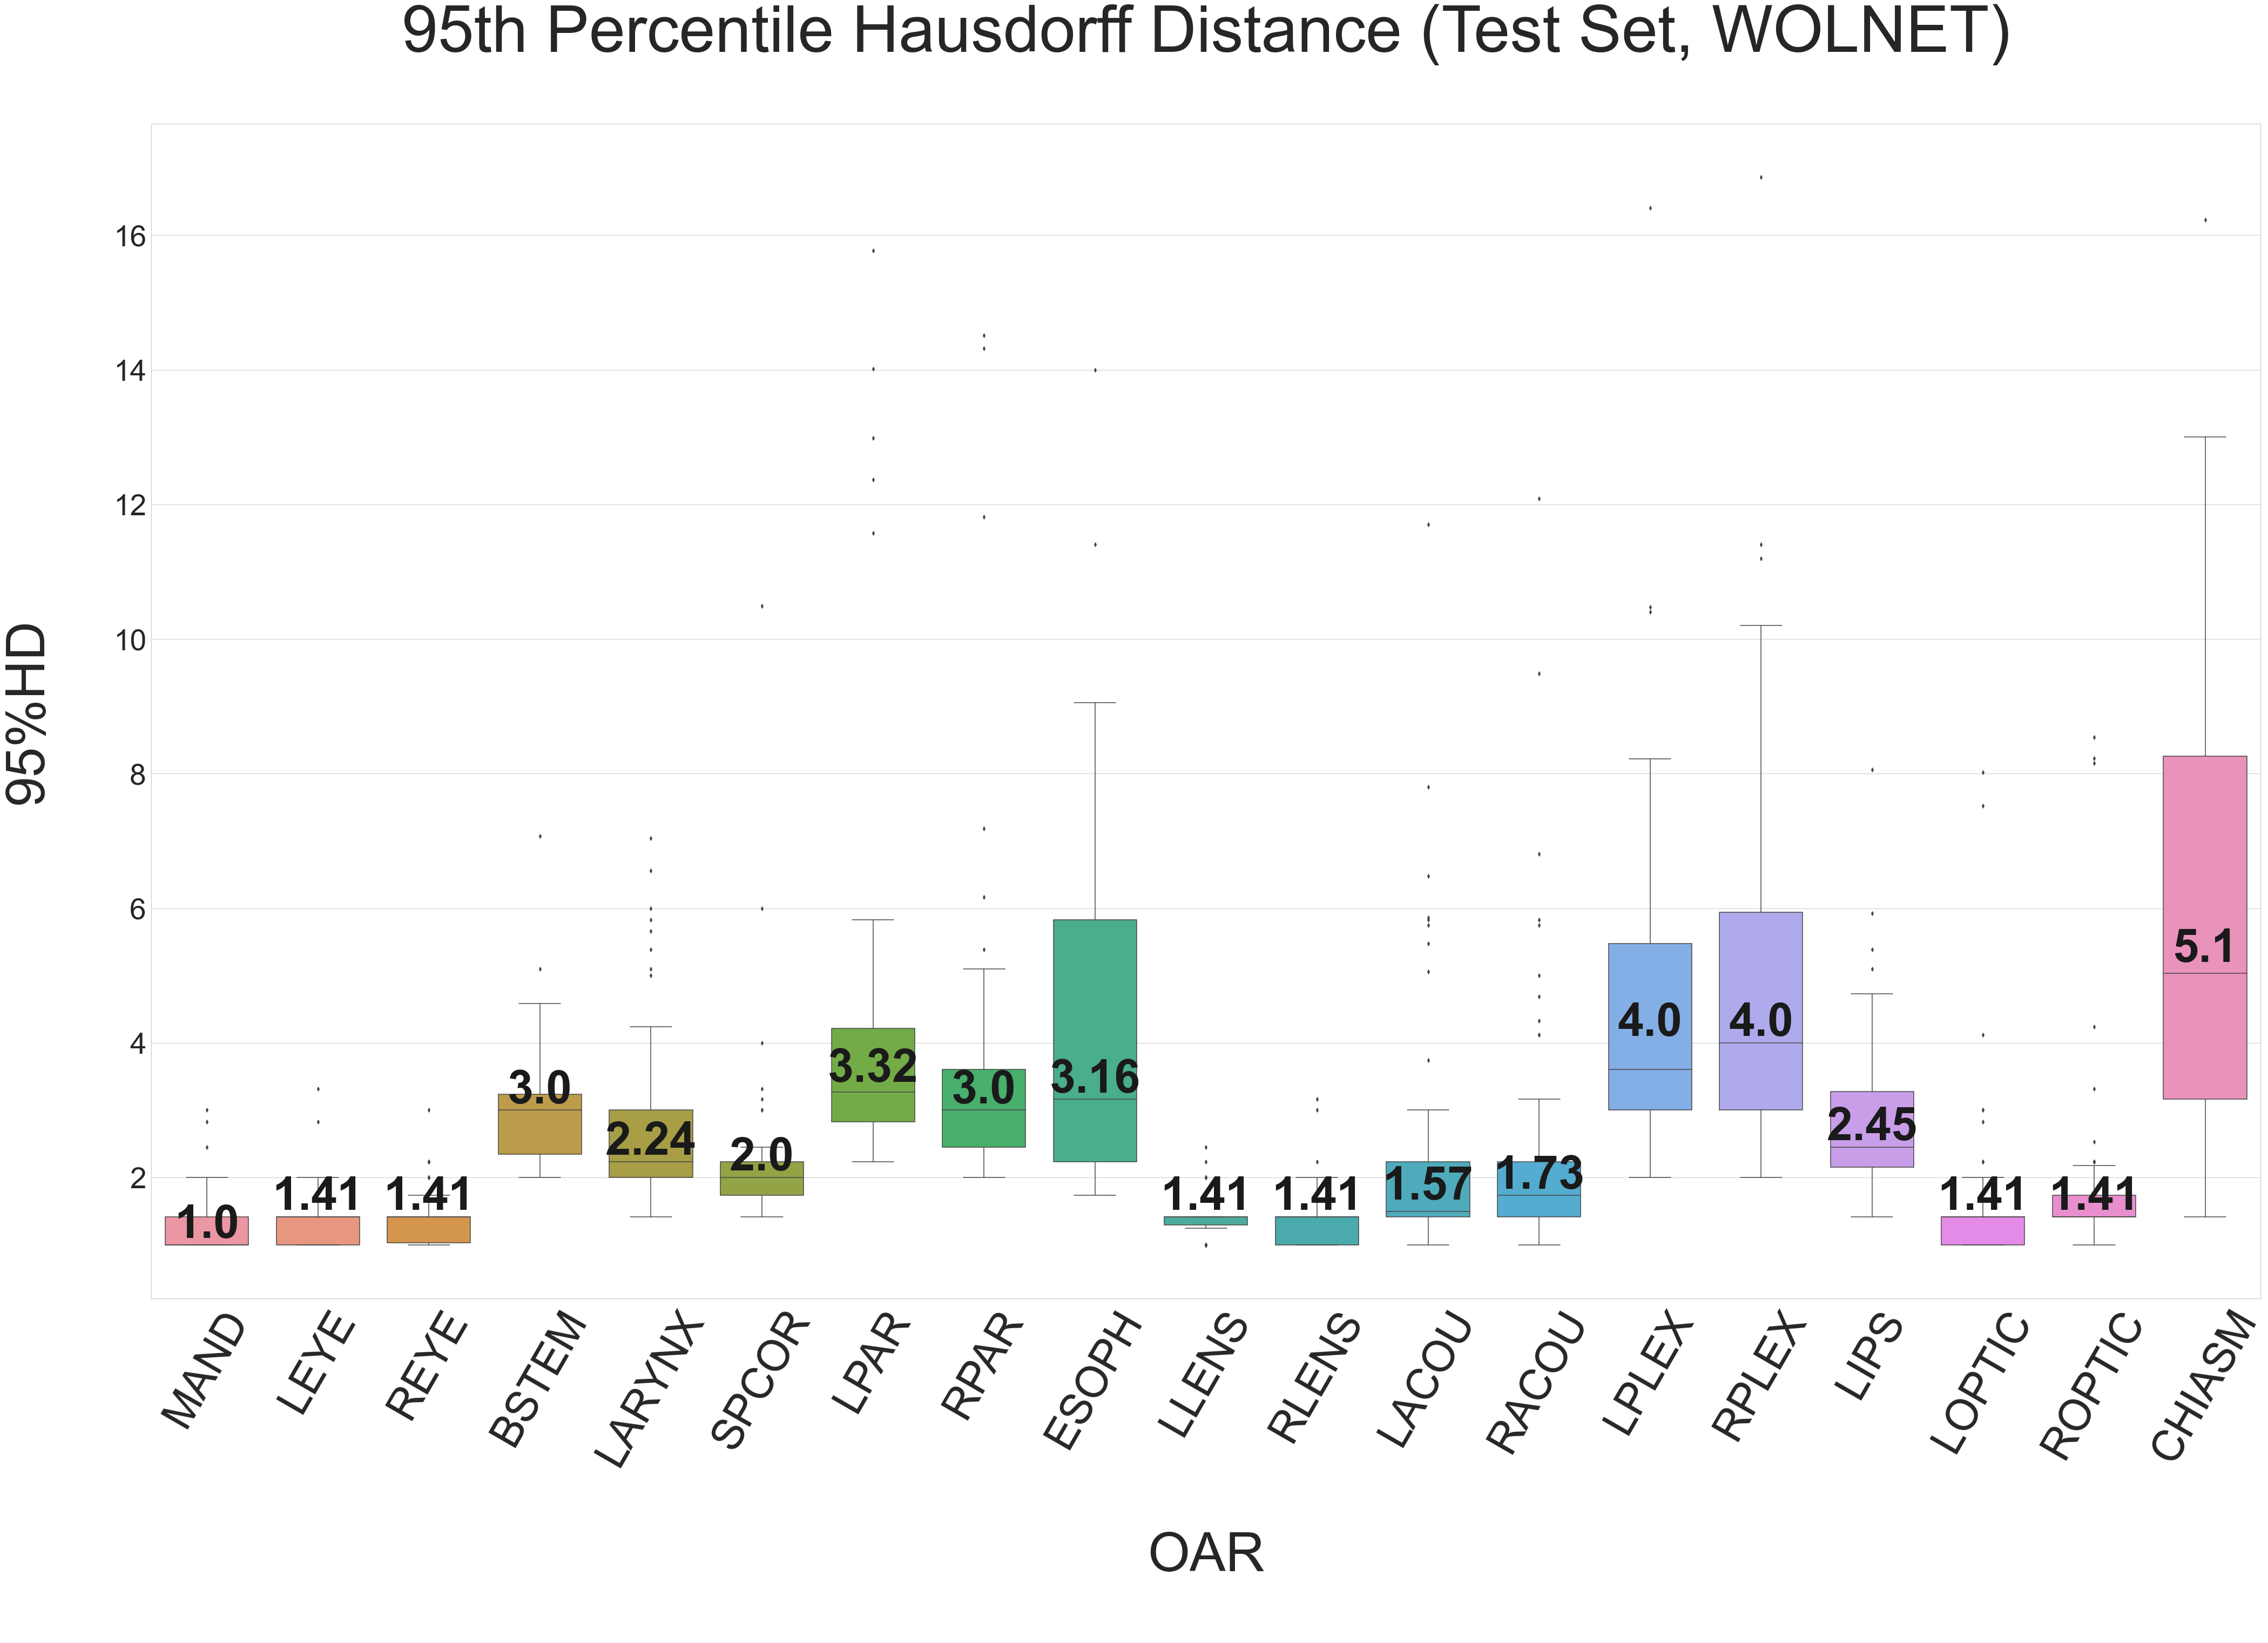

In [11]:
# CORRECTED ENSEMBLE
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data_[data_["95HD"]<17.5], x="OAR", y="95HD", hue="OAR", hue_order=rois, width=.75, dodge=False)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
medians = data_.groupby(['OAR'])['95HD'].median()
vertical_offset = data_['95HD'].median() * 0.05 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
ax.legend_.remove()

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


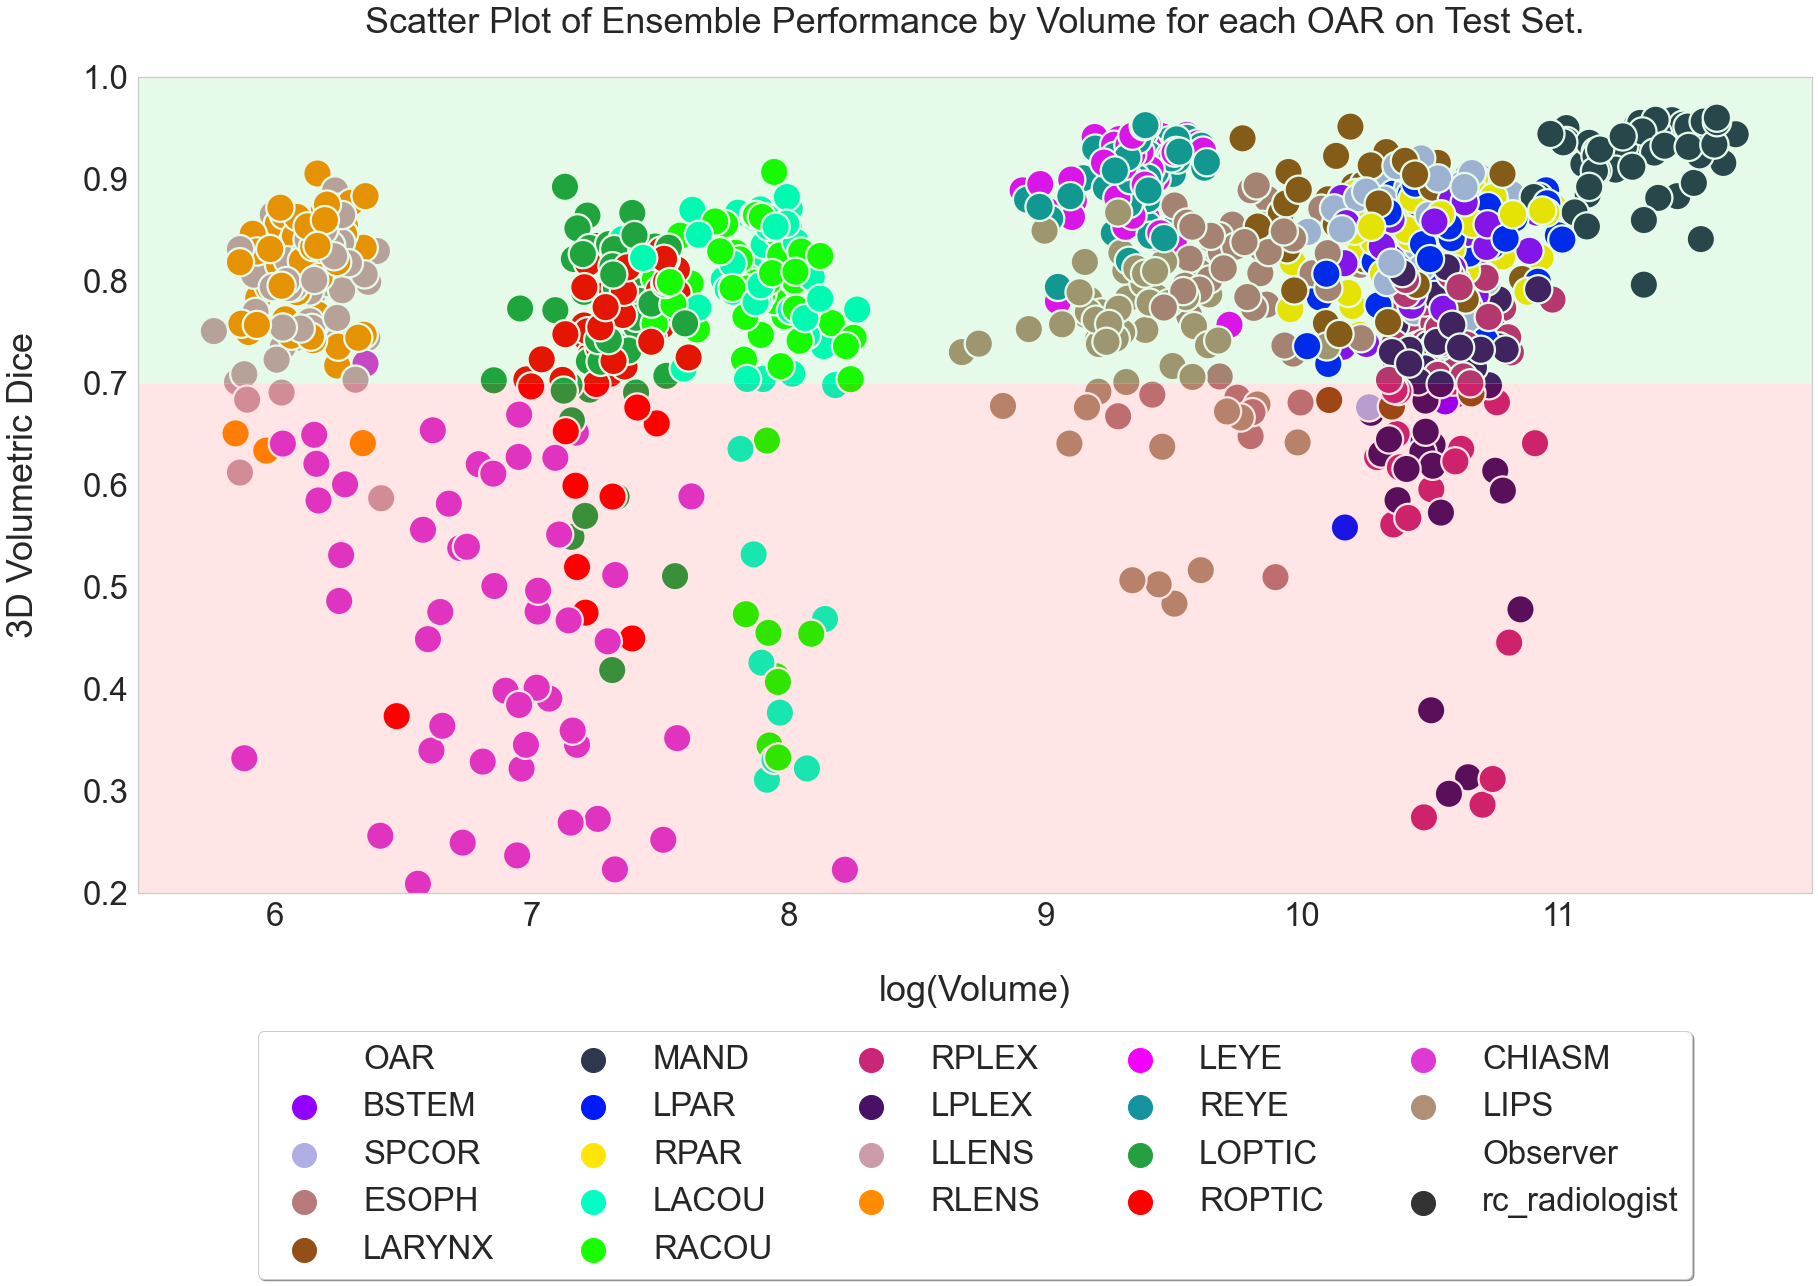

In [50]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.set_style("whitegrid")
# list of # colours...
# colors  = ['#ff0000', '#9400ff', '#0019ff', '#f200ff', '#ff8c00',
#            '#ffe500', '#24a041', '#14929e', '#c92677', '#af9077', '#00ffc3',
#            '#934f17', '#cc9da8', '#2d384f', '#481166', "#ebff16", '#19ff00',
#            "#dd39d5", '#afaee5', '#b77b7b']
# import random
# random.shuffle(colors)
sea.set_palette(sea.color_palette(colors))
sea.color_palette()
plt.title('Scatter Plot of Ensemble Performance by Volume for each OAR on Test Set.\n')
plt.ylim(0.2, 1.0)
# plt.xlim(0,9)
plt.ylabel('3D Volumetric Dice\n')
plt.xlabel('\nlog(Volume)')
exclude = []
# data_ = data_median[~data_median.OAR.isin(exclude)]
# include = ['rc_radiologist', 'stseg_radiographer']
# data_ = data_[data_.Observer.isin(include)]
data_.sort_values(["95HD"])
# data_['95HD'] = jitter(np.array(data_['95HD']), 0)
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.cat.set_categories(include, inplace=True)
# data_.sort_values(["Observer"])
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.sort(include, inplace=True)
# include = list(data_[data_['Observer']=='stseg_radiographer']['OAR'].unique())
# data_ = data_[data_.OAR.isin(include)]


# sizes = data_.groupby('OAR', as_index=False)['Counts'].sum()
# get sizes 
# obs = list(data_['Observer'])
# obu = list(data_['Observer'].unique())
# data_['Counts']*=100
# data_['95HD'] = jitter(np.array(data_['95HD']), .15)
# data_['VolDice'] = jitter(np.array(data_['VolDice']), .1)
# plt.errorbar(x=data_['95HD'], y=data_['VolDice'], yerr=data_['VolDice_std'], linestyle='', color='r', linewidth=1)
g = sea.scatterplot( data=data_, y='VolDice', x=np.log(data_['Volume']), hue='OAR', style='Observer', s=800)
# sea.scatterplot( data=data_, y='VolDice', x='95HD', hue='OAR', style='Observer', s=800)
# lh.set_sizes([50])
g.grid()
# g.margins(0) # remove default margins (matplotlib verision 2+)
g.axhspan(.7, 1., xmin=0.0,xmax=1.,facecolor='#00d326', alpha=.1)
# g.axhspan(.7, 1., xmin=0.4,xmax=1., facecolor='#ffff00', alpha=.1)
# g.axhspan(0, .7, xmin=0.0,xmax=.4,facecolor='#ffff00', alpha=.1)
g.axhspan(0, .7, xmin=0.0,xmax=1., facecolor='#ff0000', alpha=.1)
#, xerr=data_['95HD_std'])
# ax.axhspan(9, 12, facecolor='red', alpha=0.5)
leg = g.legend(markerscale=4, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5) #'lower center', bbox_to_anchor=(-0.15, -.10))
# for i, val in enumerate(leg.legendHandles):
#     val.set_markersize(50)

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


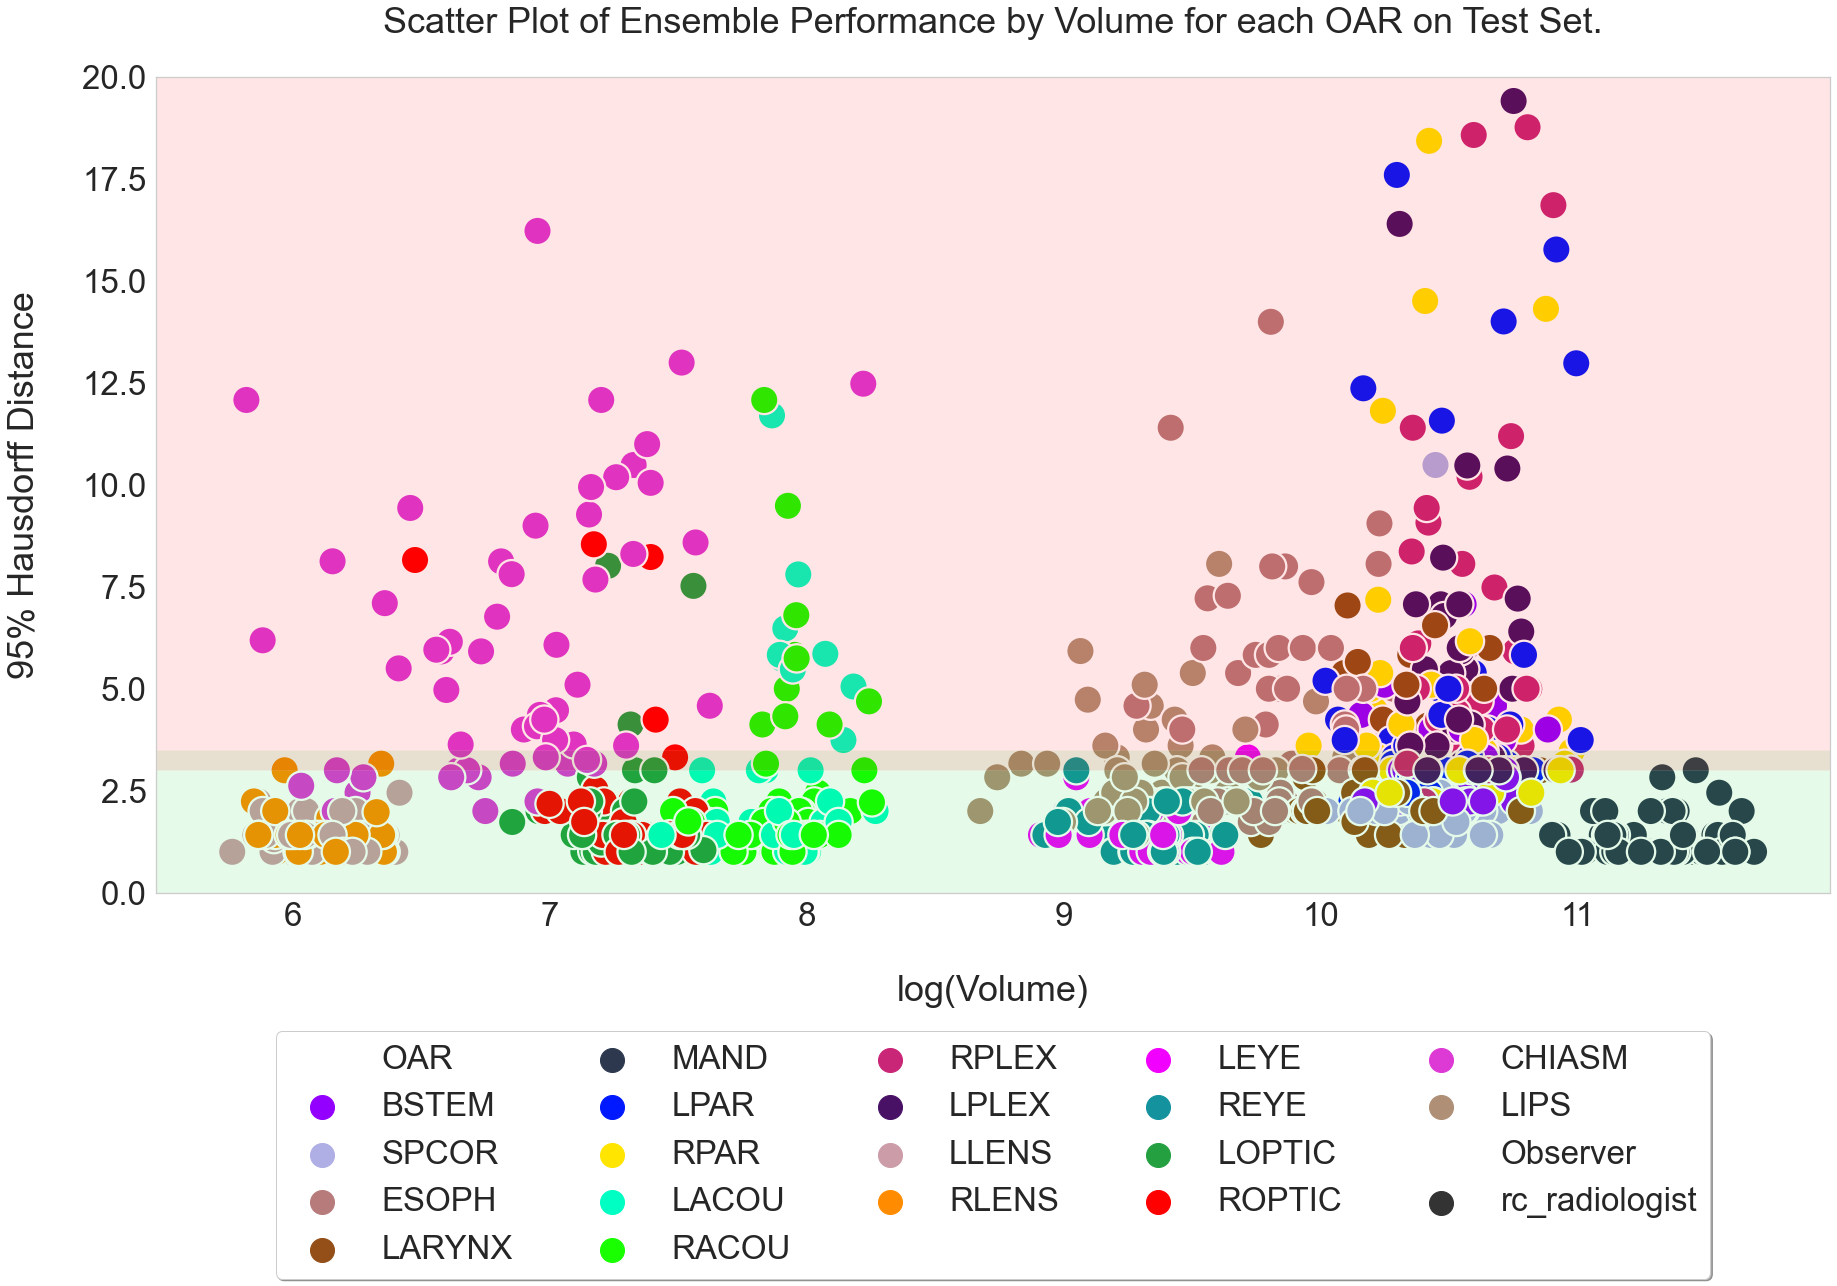

In [59]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.set_style("whitegrid")
# list of # colours...
# colors  = ['#ff0000', '#9400ff', '#0019ff', '#f200ff', '#ff8c00',
#            '#ffe500', '#24a041', '#14929e', '#c92677', '#af9077', '#00ffc3',
#            '#934f17', '#cc9da8', '#2d384f', '#481166', "#ebff16", '#19ff00',
#            "#dd39d5", '#afaee5', '#b77b7b']
# import random
# random.shuffle(colors)
sea.set_palette(sea.color_palette(colors))
sea.color_palette()
plt.title('Scatter Plot of Ensemble Performance by Volume for each OAR on Test Set.\n')
plt.ylim(0, 20)
# plt.xlim(0,9)
plt.ylabel('95% Hausdorff Distance\n')
plt.xlabel('\nlog(Volume)')
exclude = []
# data_ = data_median[~data_median.OAR.isin(exclude)]
# include = ['rc_radiologist', 'stseg_radiographer']
# data_ = data_[data_.Observer.isin(include)]
data_.sort_values(["95HD"])
# data_['95HD'] = jitter(np.array(data_['95HD']), 0)
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.cat.set_categories(include, inplace=True)
# data_.sort_values(["Observer"])
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.sort(include, inplace=True)
# include = list(data_[data_['Observer']=='stseg_radiographer']['OAR'].unique())
# data_ = data_[data_.OAR.isin(include)]


# sizes = data_.groupby('OAR', as_index=False)['Counts'].sum()
# get sizes 
# obs = list(data_['Observer'])
# obu = list(data_['Observer'].unique())
# data_['Counts']*=100
# data_['95HD'] = jitter(np.array(data_['95HD']), .15)
# data_['VolDice'] = jitter(np.array(data_['VolDice']), .1)
# plt.errorbar(x=data_['95HD'], y=data_['VolDice'], yerr=data_['VolDice_std'], linestyle='', color='r', linewidth=1)
g = sea.scatterplot( data=data_, y='95HD', x=np.log(data_['Volume']), hue='OAR', style='Observer', s=800)
# sea.scatterplot( data=data_, y='VolDice', x='95HD', hue='OAR', style='Observer', s=800)
# lh.set_sizes([50])
g.grid()
# g.margins(0) # remove default margins (matplotlib verision 2+)
g.axhspan(0., 3.5, xmin=0.0,xmax=1.,facecolor='#00d326', alpha=.1)
# g.axhspan(.7, 1., xmin=0.4,xmax=1., facecolor='#ffff00', alpha=.1)
# g.axhspan(0, .7, xmin=0.0,xmax=.4,facecolor='#ffff00', alpha=.1)
g.axhspan(3, 20., xmin=0.0,xmax=1., facecolor='#ff0000', alpha=.1)
#, xerr=data_['95HD_std'])
# ax.axhspan(9, 12, facecolor='red', alpha=0.5)
leg = g.legend(markerscale=4, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5) #'lower center', bbox_to_anchor=(-0.15, -.10))
# for i, val in enumerate(leg.legendHandles):
#     val.set_markersize(50)

['BSTEM',
 'SPCOR',
 'ESOPH',
 'LARYNX',
 'MAND',
 'LPAR',
 'RPAR',
 'LACOU',
 'RACOU',
 'RPLEX',
 'LPLEX',
 'LLENS',
 'RLENS',
 'LEYE',
 'REYE',
 'LOPTIC',
 'ROPTIC',
 'CHIASM',
 'LIPS']

In [28]:
median_r = data_.groupby('OAR', as_index=False)[['VolDice', '95HD', 'Volume']].median()
observer = ['rad_radiographer' for p in range(len(median_r))]
std = data_.groupby('OAR', as_index=False)[['VolDice', '95HD', 'Volume']].std()
median_r['VolDice_std'] = std['VolDice']
median_r['95HD_std'] = std['95HD']
median_r['Volume_std'] = std['Volume']
median_r['Observer'] = observer
sorted_ = data_.groupby('OAR', as_index=True)['OAR']
median_r['Counts'] = np.array(sorted_.count())

In [ ]:
# list of # colours...
colors  = ['#ff0000', '#9400ff', '#0019ff', '#f200ff', '#ff8c00',
           '#ffe500', '#24a041', '#14929e', '#c92677', '#af9077', '#00ffc3',
           '#934f17', '#cc9da8', '#2d384f', '#481166', "#ebff16", '#19ff00',
           "#dd39d5", '#afaee5', '#b77b7b']
import random
random.shuffle(colors)

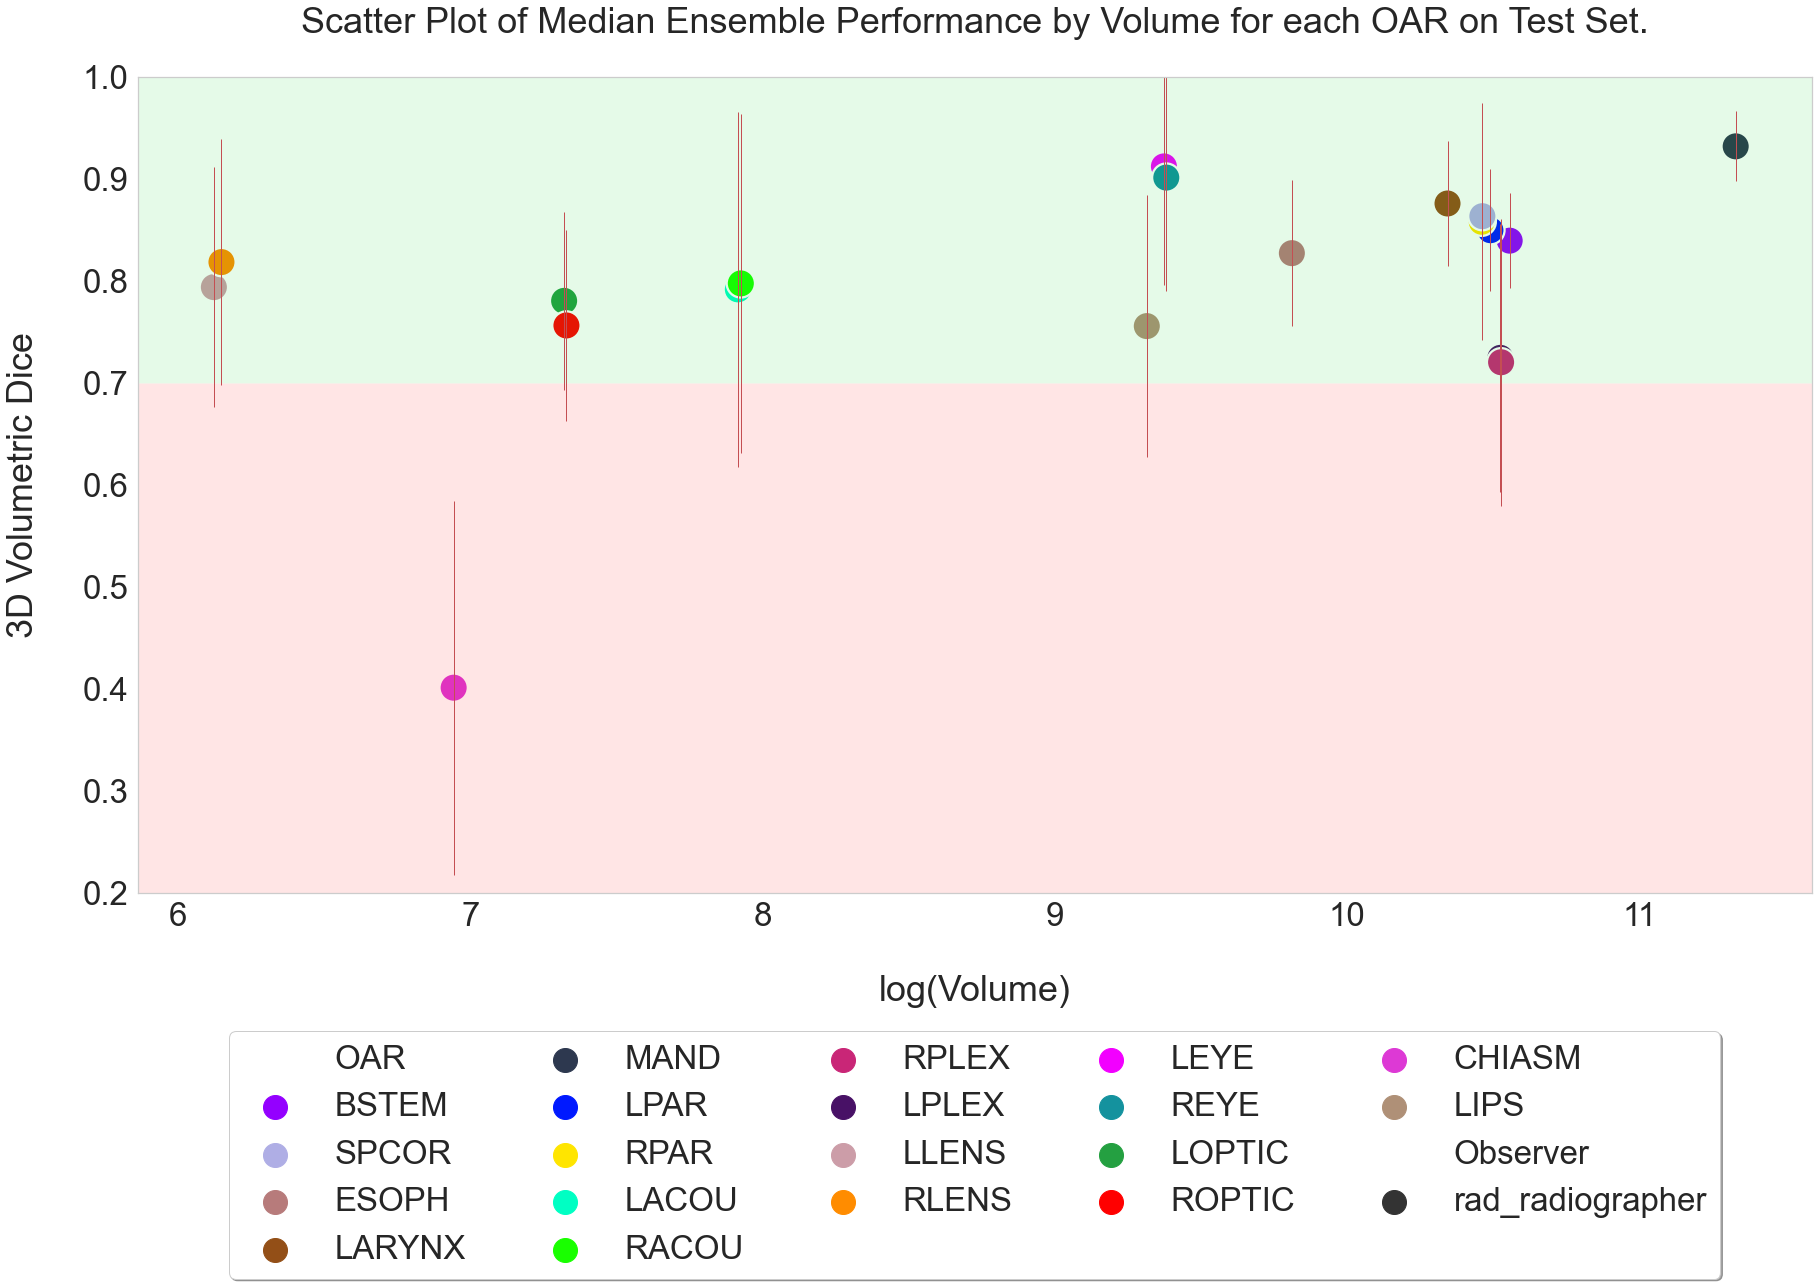

In [62]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.set_style("whitegrid")
# list of # colours...
# colors  = ['#ff0000', '#9400ff', '#0019ff', '#f200ff', '#ff8c00',
#            '#ffe500', '#24a041', '#14929e', '#c92677', '#af9077', '#00ffc3',
#            '#934f17', '#cc9da8', '#2d384f', '#481166', "#ebff16", '#19ff00',
#            "#dd39d5", '#afaee5', '#b77b7b']
# import random
# random.shuffle(colors)
sea.set_palette(sea.color_palette(colors))
sea.color_palette()
plt.title('Scatter Plot of Median Ensemble Performance by Volume for each OAR on Test Set.\n')
plt.ylim(0.2, 1.0)
# plt.xlim(0,9)
plt.ylabel('3D Volumetric Dice\n')
plt.xlabel('\nlog(Volume)')
exclude = []
# data_ = data_median[~data_median.OAR.isin(exclude)]
# include = ['rc_radiologist', 'stseg_radiographer']
# data_ = data_[data_.Observer.isin(include)]
median_r.sort_values(["95HD"])
# data_['95HD'] = jitter(np.array(data_['95HD']), 0)
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.cat.set_categories(include, inplace=True)
# data_.sort_values(["Observer"])
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.sort(include, inplace=True)
# include = list(data_[data_['Observer']=='stseg_radiographer']['OAR'].unique())
# data_ = data_[data_.OAR.isin(include)]


# sizes = data_.groupby('OAR', as_index=False)['Counts'].sum()
# get sizes 
# obs = list(data_['Observer'])
# obu = list(data_['Observer'].unique())
# data_['Counts']*=100
# data_['95HD'] = jitter(np.array(data_['95HD']), .15)
# data_['VolDice'] = jitter(np.array(data_['VolDice']), .1)
plt.errorbar(x=np.log(median_r['Volume']), y=median_r['VolDice'], yerr=median_r['VolDice_std'], linestyle='', color='r', linewidth=1)
g = sea.scatterplot( data=median_r, y='VolDice', x=np.log(median_r['Volume']), hue='OAR', hue_order=list(data_.OAR.unique()), style='Observer', s=800)
# sea.scatterplot( data=data_, y='VolDice', x='95HD', hue='OAR', style='Observer', s=800)
# lh.set_sizes([50])
g.grid()
# g.margins(0) # remove default margins (matplotlib verision 2+)
g.axhspan(.7, 1., xmin=0.0,xmax=1.,facecolor='#00d326', alpha=.1)
# g.axhspan(.7, 1., xmin=0.4,xmax=1., facecolor='#ffff00', alpha=.1)
# g.axhspan(0, .7, xmin=0.0,xmax=.4,facecolor='#ffff00', alpha=.1)
g.axhspan(0, .7, xmin=0.0,xmax=1., facecolor='#ff0000', alpha=.1)
#, xerr=data_['95HD_std'])
# ax.axhspan(9, 12, facecolor='red', alpha=0.5)
leg = g.legend(markerscale=4, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5) #'lower center', bbox_to_anchor=(-0.15, -.10))
# for i, val in enumerate(leg.legendHandles):
#     val.set_markersize(50)

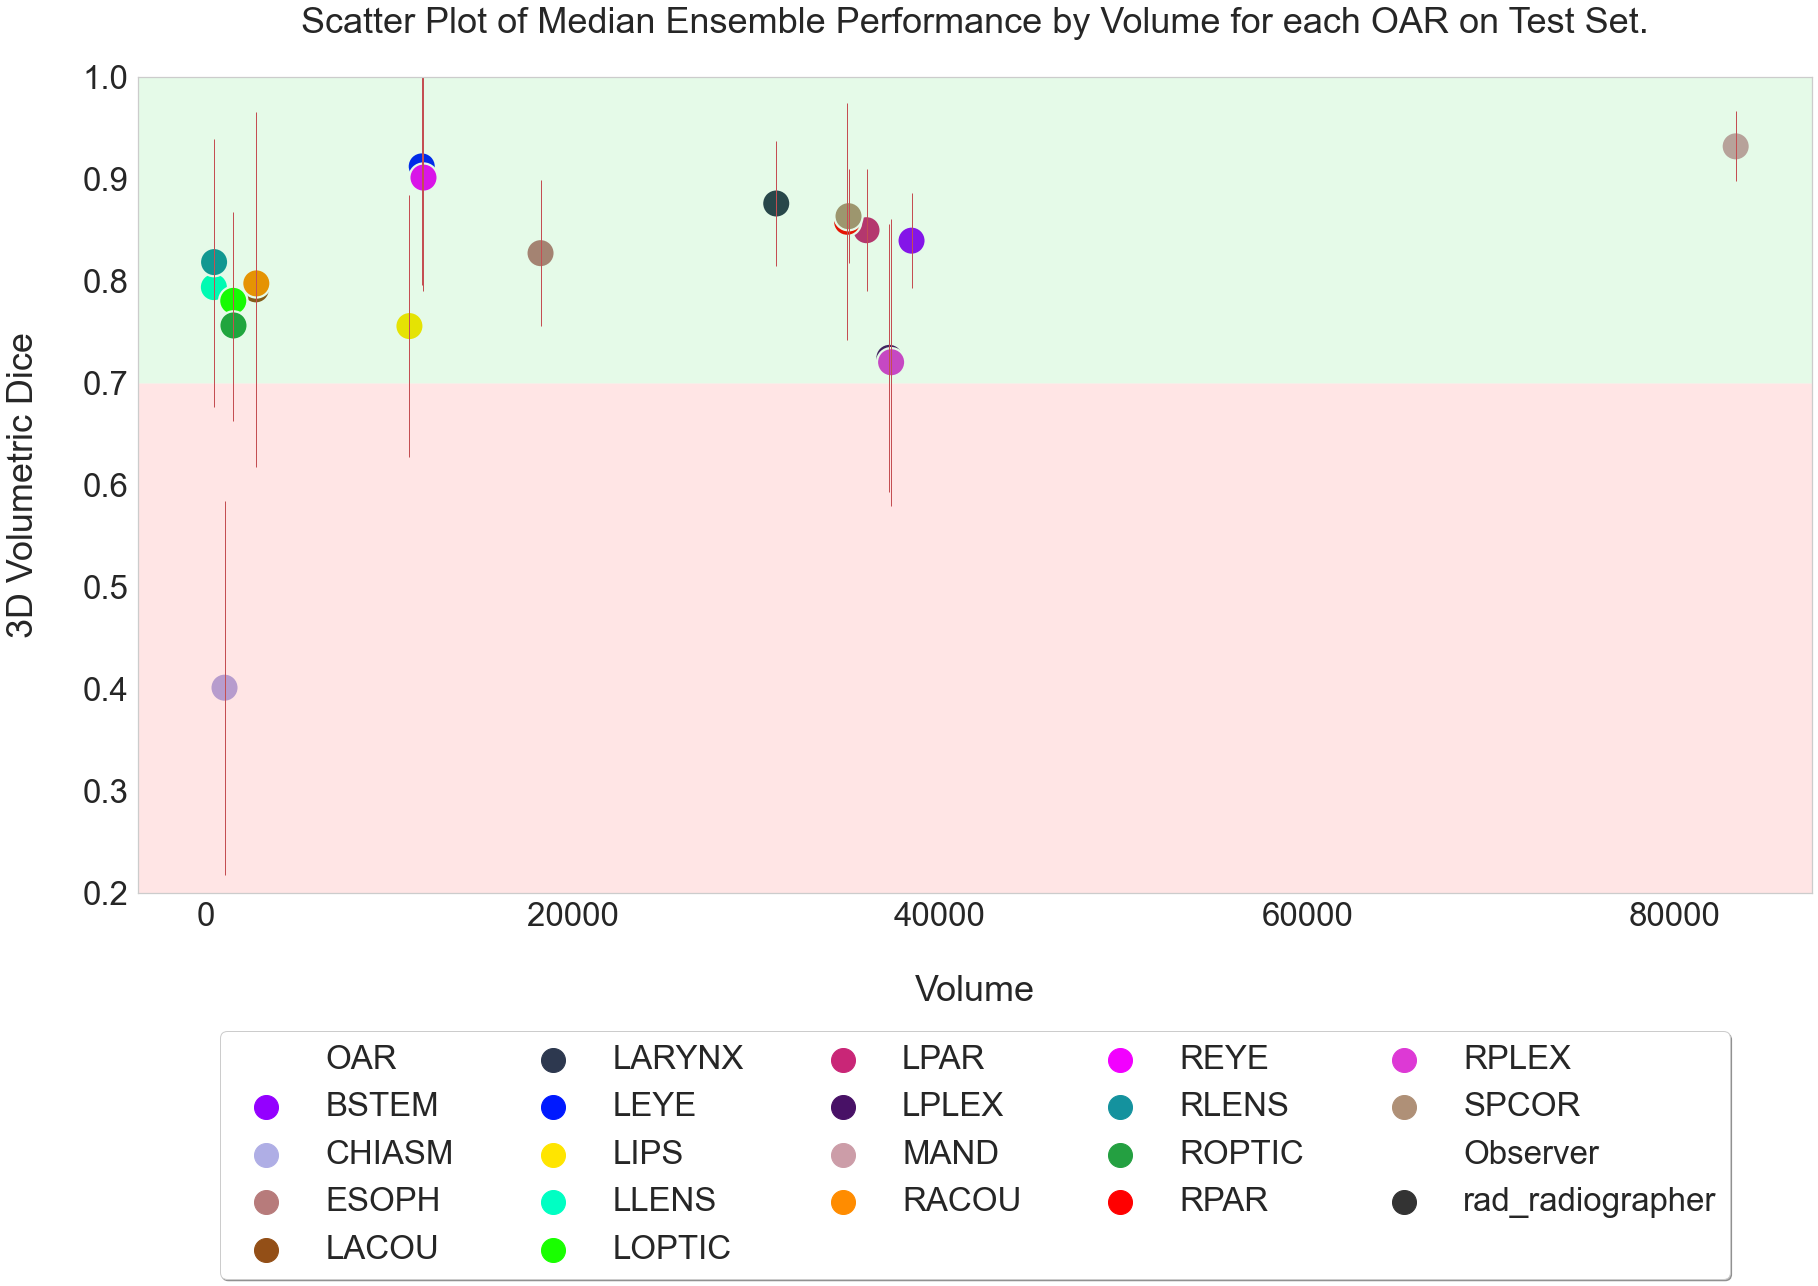

In [ ]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.set_style("whitegrid")
sea.set_palette(sea.color_palette(colors))
sea.color_palette()
plt.title('Scatter Plot of Median Ensemble Performance by Volume for each OAR on Test Set.\n')
plt.ylim(0.2, 1.0)
# plt.xlim(0,9)
plt.ylabel('3D Volumetric Dice\n')
plt.xlabel('\nVolume')
exclude = []
# data_ = data_median[~data_median.OAR.isin(exclude)]
# include = ['rc_radiologist', 'stseg_radiographer']
# data_ = data_[data_.Observer.isin(include)]
median_r.sort_values(["95HD"])
# data_['95HD'] = jitter(np.array(data_['95HD']), 0)
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.cat.set_categories(include, inplace=True)
# data_.sort_values(["Observer"])
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.sort(include, inplace=True)
# include = list(data_[data_['Observer']=='stseg_radiographer']['OAR'].unique())
# data_ = data_[data_.OAR.isin(include)]


# sizes = data_.groupby('OAR', as_index=False)['Counts'].sum()
# get sizes 
# obs = list(data_['Observer'])
# obu = list(data_['Observer'].unique())
# data_['Counts']*=100
# data_['95HD'] = jitter(np.array(data_['95HD']), .15)
# data_['VolDice'] = jitter(np.array(data_['VolDice']), .1)
plt.errorbar(x=median_r['Volume'], y=median_r['VolDice'], yerr=median_r['VolDice_std'], linestyle='', color='r', linewidth=1)
g = sea.scatterplot( data=median_r, y='VolDice', x=median_r['Volume'], hue='OAR', style='Observer', s=800)
# sea.scatterplot( data=data_, y='VolDice', x='95HD', hue='OAR', style='Observer', s=800)
# lh.set_sizes([50])
g.grid()
# g.margins(0) # remove default margins (matplotlib verision 2+)
g.axhspan(.7, 1., xmin=0.0,xmax=1.,facecolor='#00d326', alpha=.1)
# g.axhspan(.7, 1., xmin=0.4,xmax=1., facecolor='#ffff00', alpha=.1)
# g.axhspan(0, .7, xmin=0.0,xmax=.4,facecolor='#ffff00', alpha=.1)
g.axhspan(0, .7, xmin=0.0,xmax=1., facecolor='#ff0000', alpha=.1)
#, xerr=data_['95HD_std'])
# ax.axhspan(9, 12, facecolor='red', alpha=0.5)
leg = g.legend(markerscale=4, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5) #'lower center', bbox_to_anchor=(-0.15, -.10))
# for i, val in enumerate(leg.legendHandles):
#     val.set_markersize(50)

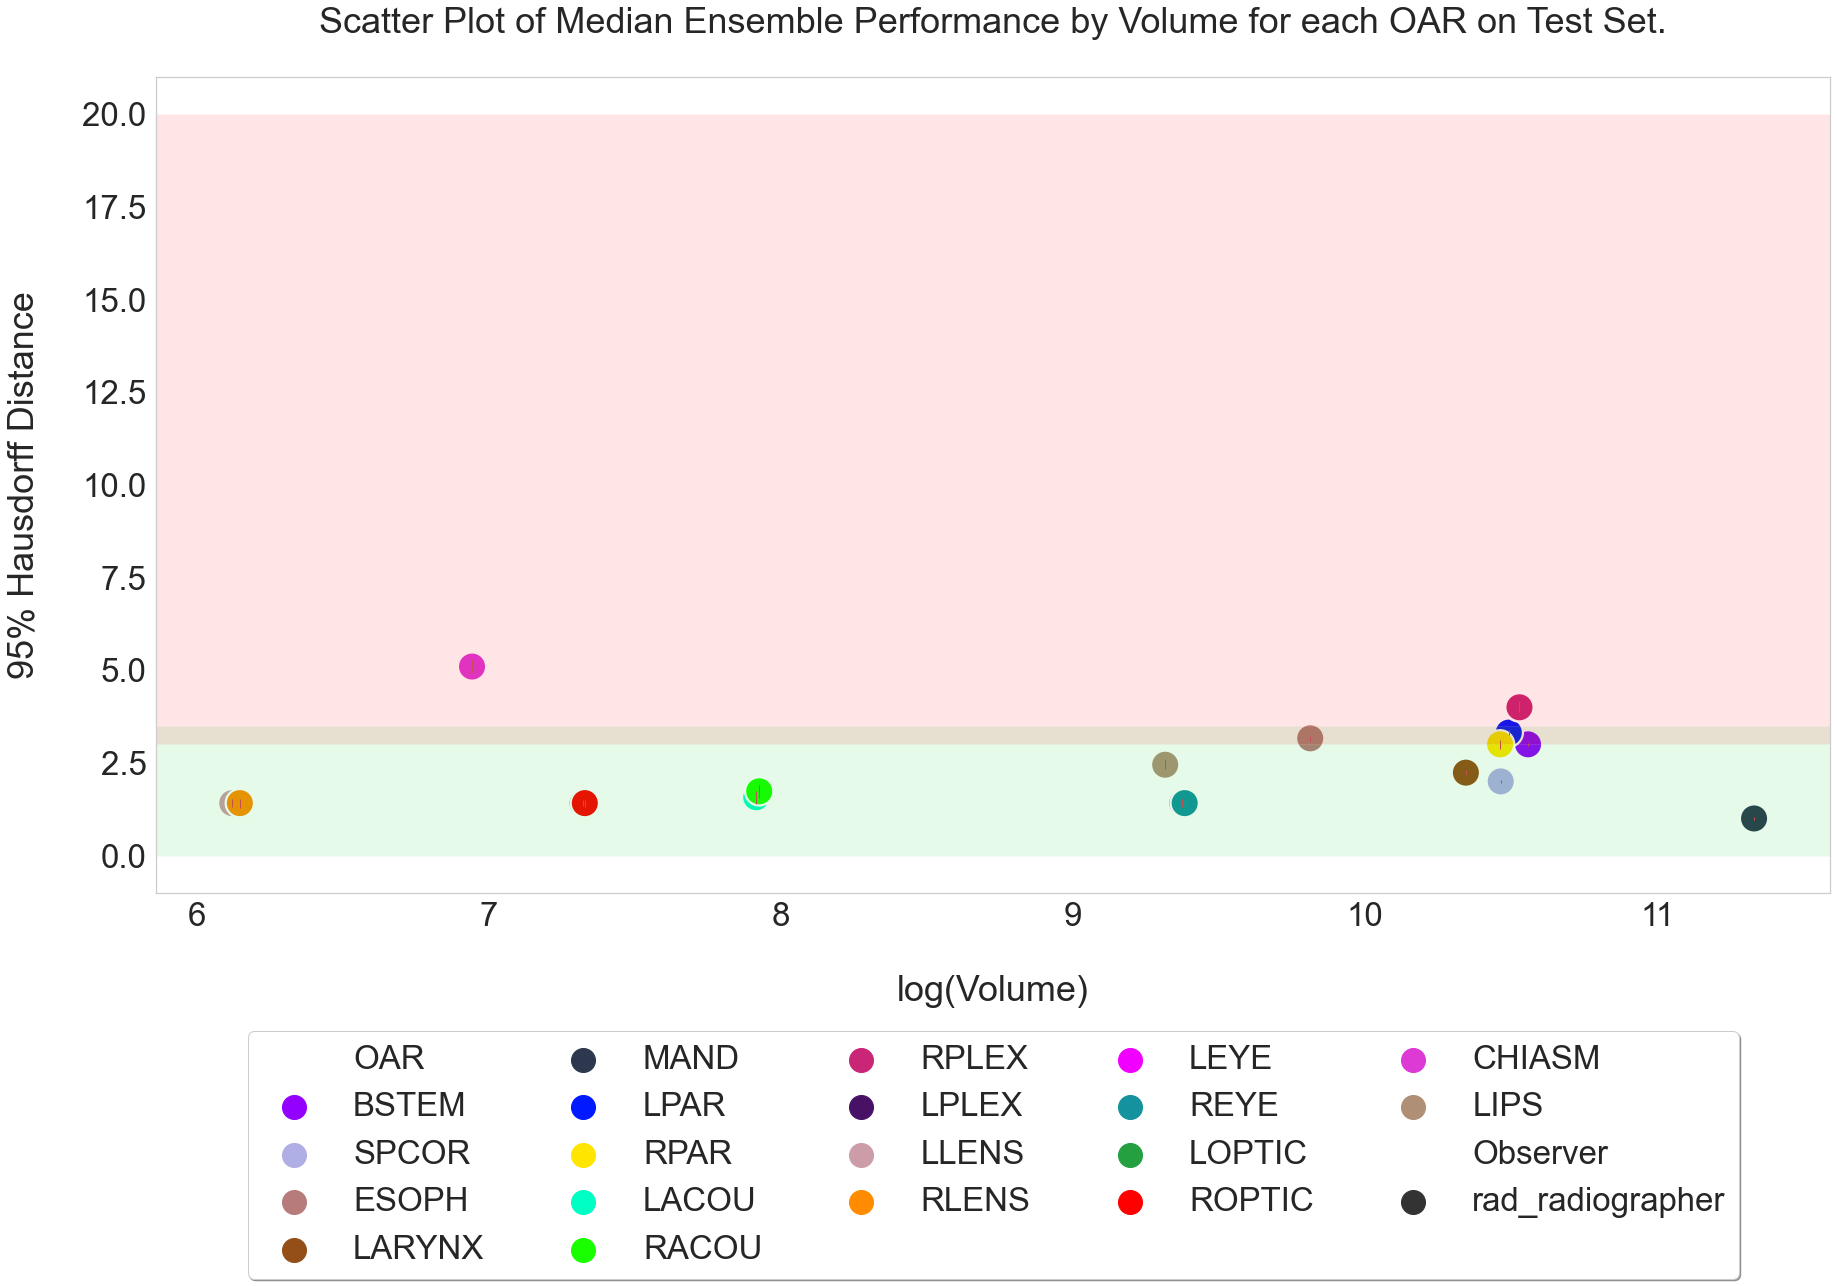

In [63]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.set_style("whitegrid")
sea.set_palette(sea.color_palette(colors))
sea.color_palette()
plt.title('Scatter Plot of Median Ensemble Performance by Volume for each OAR on Test Set.\n')
# plt.ylim(0.2, 1.0)
# plt.xlim(0,9)
plt.ylabel('95% Hausdorff Distance\n')
plt.xlabel('\nlog(Volume)')
exclude = []
# data_ = data_median[~data_median.OAR.isin(exclude)]
# include = ['rc_radiologist', 'stseg_radiographer']
# data_ = data_[data_.Observer.isin(include)]
median_r.sort_values(["95HD"])
# data_['95HD'] = jitter(np.array(data_['95HD']), 0)
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.cat.set_categories(include, inplace=True)
# data_.sort_values(["Observer"])
# data_.Observer = data_.Observer.astype("category")
# data_.Observer.sort(include, inplace=True)
# include = list(data_[data_['Observer']=='stseg_radiographer']['OAR'].unique())
# data_ = data_[data_.OAR.isin(include)]


# sizes = data_.groupby('OAR', as_index=False)['Counts'].sum()
# get sizes 
# obs = list(data_['Observer'])
# obu = list(data_['Observer'].unique())
# data_['Counts']*=100
# data_['95HD'] = jitter(np.array(data_['95HD']), .15)
# data_['VolDice'] = jitter(np.array(data_['VolDice']), .1)
plt.errorbar(x=np.log(median_r['Volume']), y=median_r['95HD'], yerr=median_r['VolDice_std'], linestyle='', color='r', linewidth=1)
g = sea.scatterplot( data=median_r, y='95HD', x=np.log(median_r['Volume']), hue='OAR', hue_order=list(data_.OAR.unique()), style='Observer', s=800)
# sea.scatterplot( data=data_, y='VolDice', x='95HD', hue='OAR', style='Observer', s=800)
# lh.set_sizes([50])
g.grid()
# g.margins(0) # remove default margins (matplotlib verision 2+)
g.axhspan(0., 3.5, xmin=0.0,xmax=1.,facecolor='#00d326', alpha=.1)
# g.axhspan(.7, 1., xmin=0.4,xmax=1., facecolor='#ffff00', alpha=.1)
# g.axhspan(0, .7, xmin=0.0,xmax=.4,facecolor='#ffff00', alpha=.1)
g.axhspan(3, 20., xmin=0.0,xmax=1., facecolor='#ff0000', alpha=.1)
#, xerr=data_['95HD_std'])
# ax.axhspan(9, 12, facecolor='red', alpha=0.5)
leg = g.legend(markerscale=4, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5) #'lower center', bbox_to_anchor=(-0.15, -.10))
# for i, val in enumerate(leg.legendHandles):
#     val.set_markersize(50)

In [1]:
# correlation with VOLUME and performance metrics... (Could be another great correlation)
import pandas as pd

In [2]:
data = pd.read_csv('/Users/joemarsilla/OARensemble2021_corrected_01072022.csv', index_col=0)

In [3]:
data.head()

OAR  Patient   VolDice      95HD  SurfDice   Volume        Observer
0   BSTEM        0  0.850081  3.000000  1.134316  40564.0  rc_radiologist
1   SPCOR        0  0.827113  2.236068  1.092190  40662.0  rc_radiologist
2   ESOPH        0  0.833083  3.162278  1.103672  19698.0  rc_radiologist
3  LARYNX        0  0.895342  2.000000  0.853980  41646.0  rc_radiologist
4    MAND        0  0.951560  1.000000  0.346290  86006.0  rc_radiologist

In [8]:
import seaborn as sea
import matplotlib.pyplot as plt

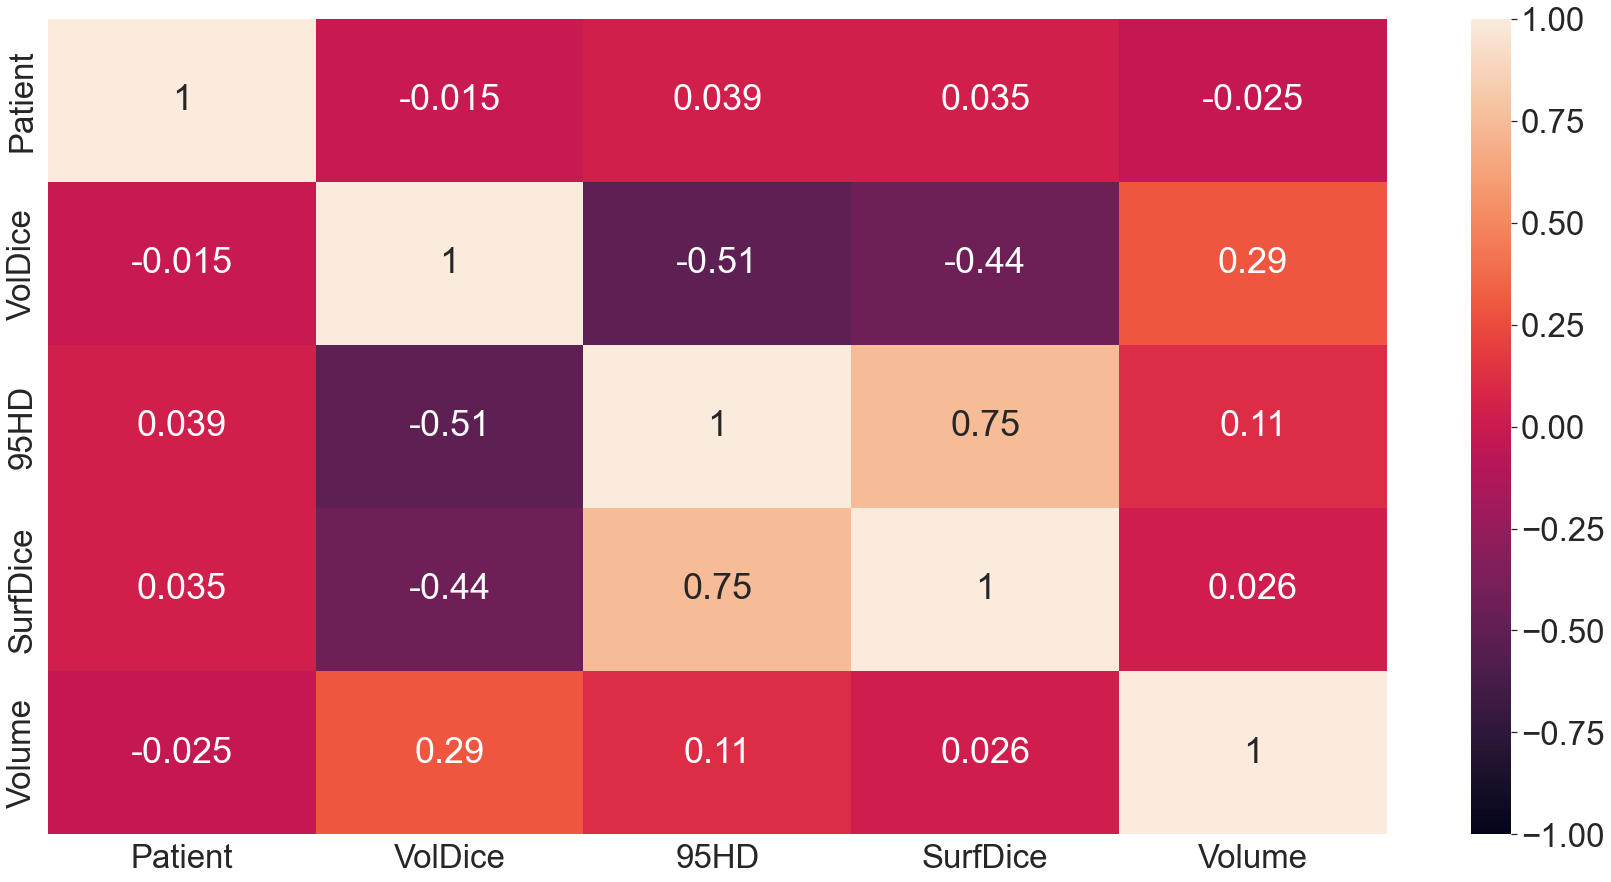

In [9]:
plt.figure(figsize=(30,15))
sea.set(font_scale=3)  # crazy big
sea.heatmap(data.corr(), vmin=-1, vmax=1, annot=True);